In [1]:
# This is used to increase the notebook's width to fill the screen, allowing for better plot visualization
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

import os
import cv2
import time
import shutil
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()

from utils import plot
from utils import split

C:\Users\leoar\AppData\Local\Temp\ipykernel_10592\659568940.py:2: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


# The TCIA (The Cancer Imaging Archive) Dataset

These retrospective NIfTI image datasets consists of unenhanced chest CTs: 

- First dataset - from 632 patients with COVID-19 infections at initial point of care, and
- Second dataset - a second set of 121 CTs from 29 patients with COVID-19 infections with serial / sequential CTs.

The initial images for both datasets were acquired at the point of care in an outbreak setting from patients with Reverse Transcription Polymerase Chain Reaction (RT-PCR) confirmation for the presence of SARS-CoV-2.

Patients presented to a health care setting with a combination of symptoms, exposure to an infected patient, or travel history to an outbreak region. All patients had a positive RT-PCR for SARS-CoV-2 from a sample obtained within 1 day of the initial CT. CT exams were performed without intravenous contrast and with a soft tissue reconstruction algorithm.  The DICOM images were subsequently converted into NIfTI format. The second dataset also had other follow up CTs, in addition to the initial point of care CT.

A multidisciplinary team trained several models using portions of the first dataset, along with additional CTs and manually annotated images from other sources. A classification model derived in part from the first dataset is described in a Nature Communications manuscript at:  https://doi.org/10.1038/s41467-020-17971-2.  The NVIDIA-related frameworks and models specific to this publication are available at no cost as part of the NVIDIA Clara Train SDK at https://ngc.nvidia.com/catalog/containers/nvidia:clara:ai-covid-19. This includes both inference-based pipelines for evaluation, as well as model weights for further training or fine tuning in outside institutions. The second data set of 121 serial / sequential CTs in 29 patients is reported in a Scientific Reports manuscript at  https://doi.org/10.1038/s41598-021-85694-5. 

## [Source](https://wiki.cancerimagingarchive.net/display/Public/CT+Images+in+COVID-19#70227107bcab02c187174a288dbcbf95d26179e8)

# Path to Dataset

In [2]:
# Relative path to dataset
data_dir = os.path.join( "..", "..", "..", "..", "Datasets", "COVID19", "Tomografia", "COVIDx CT-3A" )
assert os.path.exists( data_dir ), "Unable to find the relative path to COVIDx CT-3A, please check data_dir..."

#
dataset_name = "TCIA"

## Samples Dataframe

In [3]:
# Path to metadata csv
csv_path = os.path.join( data_dir, "combined_metadata.csv" )

# Reads metadata as dataframe, "age" column is treated as str since "N/A" can't be int
samples_df = pd.read_csv(csv_path, sep = ";", na_filter = False, dtype={"age": str})

samples_df.head()

,filename,patient_id,source,class,country,sex,age,partition,slice_selection,x_min,y_min,x_max,y_max,verified_finding,view,modality
0,NCP_96_1328_0032.png,NCP_96,CNCB,COVID-19,China,M,74.0,train,Expert,9,94,512,405,Yes,Axial,CT
1,NCP_96_1328_0035.png,NCP_96,CNCB,COVID-19,China,M,74.0,train,Expert,10,106,512,405,Yes,Axial,CT
2,NCP_96_1328_0036.png,NCP_96,CNCB,COVID-19,China,M,74.0,train,Expert,10,105,512,406,Yes,Axial,CT
3,NCP_96_1328_0037.png,NCP_96,CNCB,COVID-19,China,M,74.0,train,Expert,11,104,512,406,Yes,Axial,CT
4,NCP_96_1328_0038.png,NCP_96,CNCB,COVID-19,China,M,74.0,train,Expert,11,103,512,406,Yes,Axial,CT


## Patients Dataframe

In [4]:
# Creates a new dataframe with metadata sorted by patient
patient_df = plot.convert_df_sample2patient( samples_df )

patient_df.head()

,patient_id,source,class,country,sex,age,partition,slice_selection,verified_finding,view,modality,sample_count
0,NCP_96,CNCB,COVID-19,China,M,74.0,train,Expert,Yes,Axial,CT,121
1,NCP_270,CNCB,COVID-19,China,N/A,N/A,train,Expert,Yes,Axial,CT,124
2,NCP_322,CNCB,COVID-19,China,N/A,N/A,train,Expert,Yes,Axial,CT,40
3,NCP_1276,CNCB,COVID-19,China,N/A,N/A,train,Expert,Yes,Axial,CT,32
4,NCP_2683,CNCB,COVID-19,China,N/A,N/A,train,Expert,Yes,Axial,CT,9


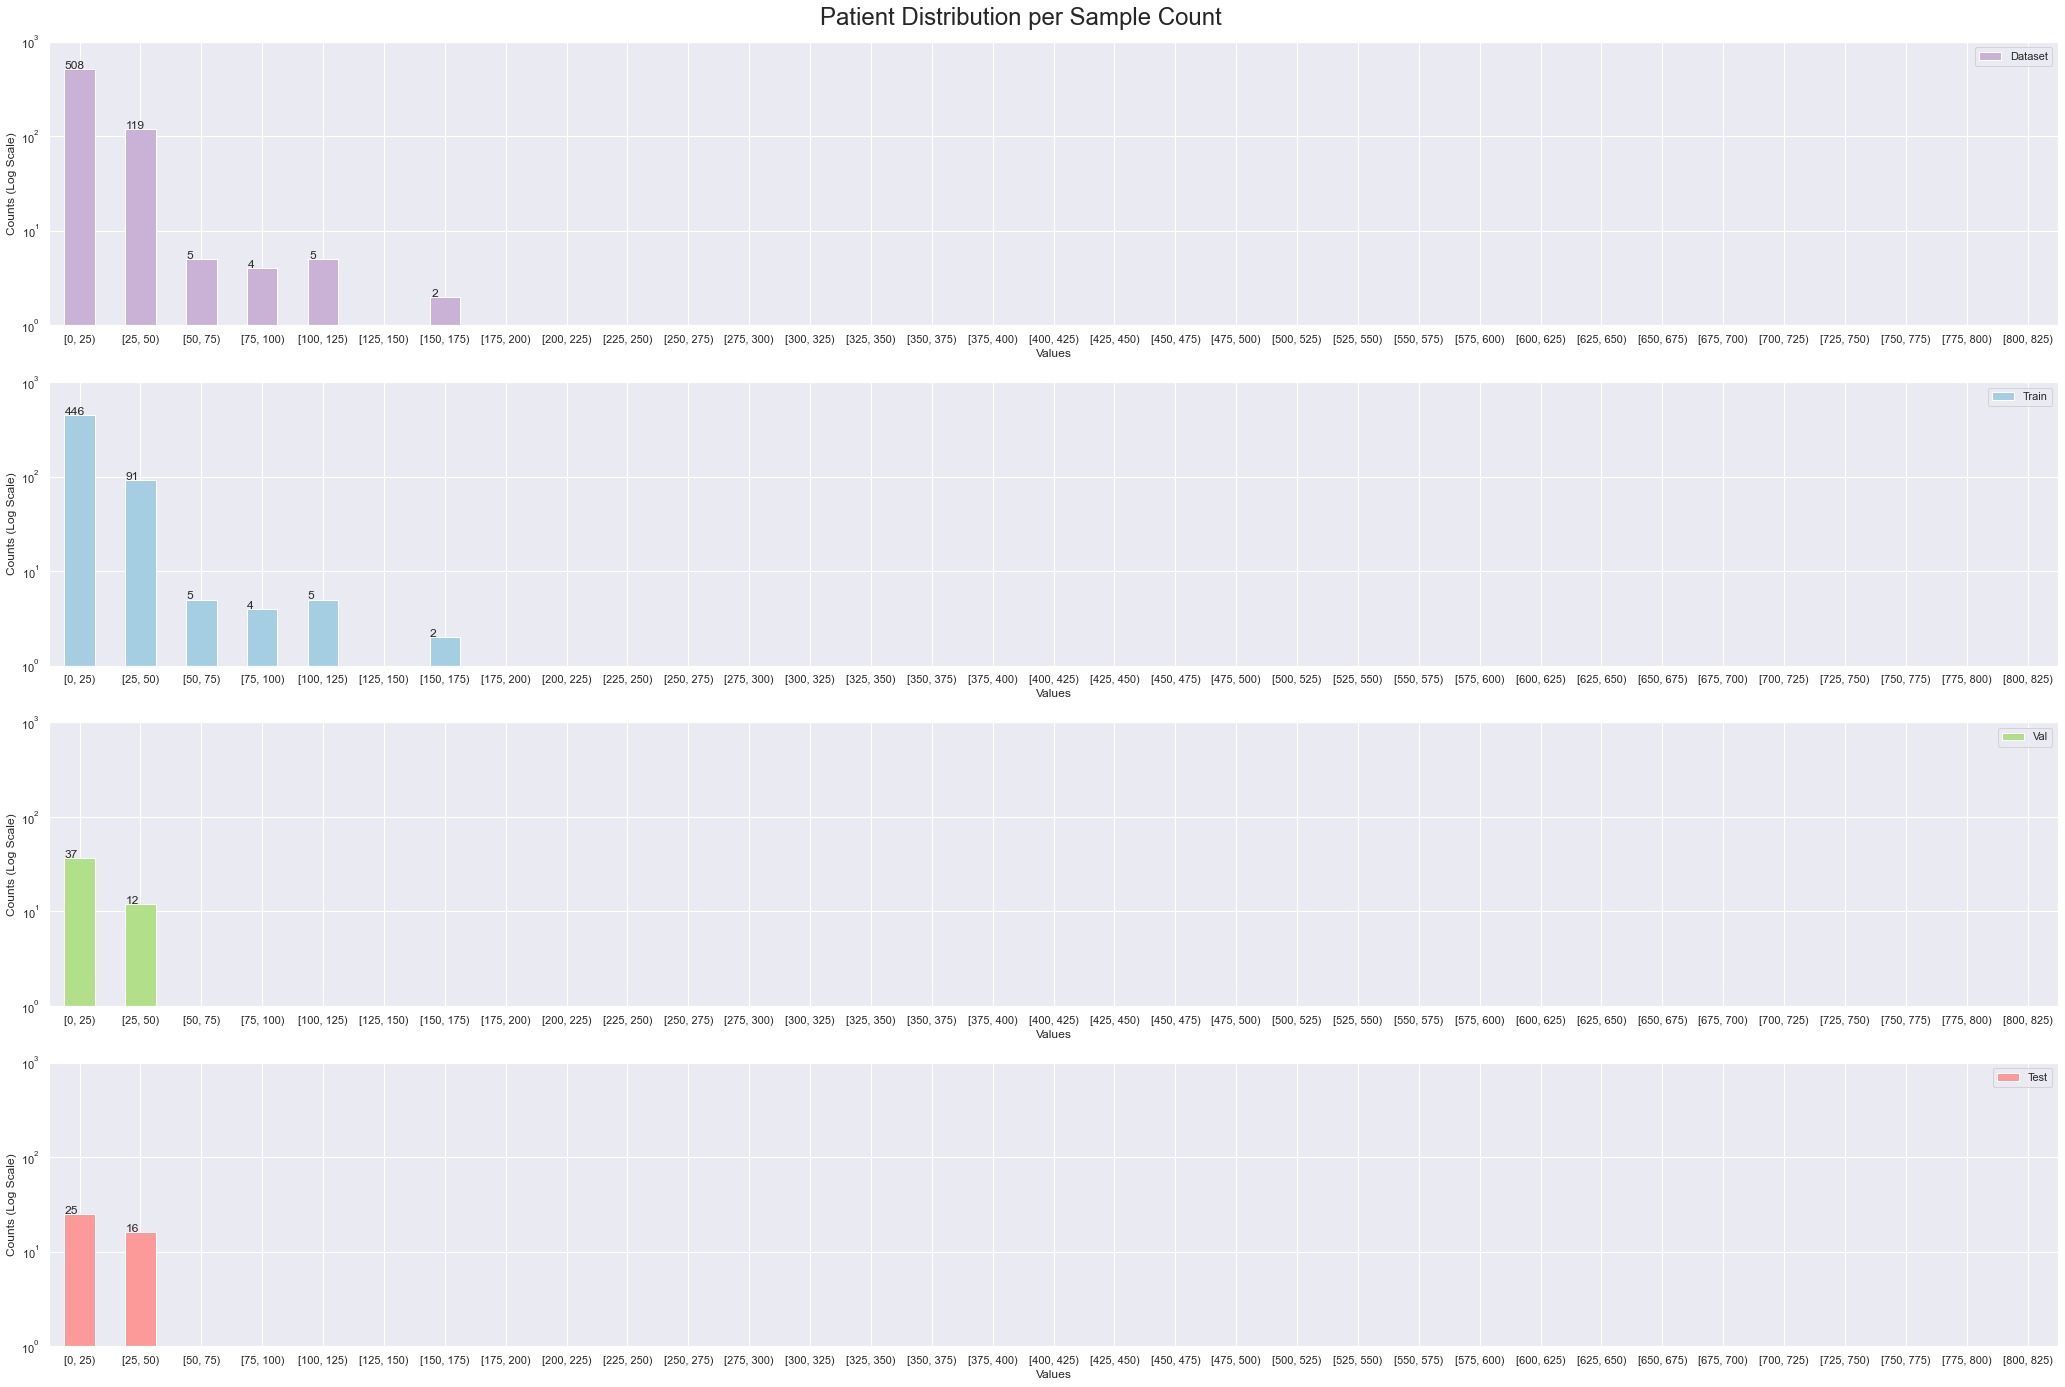

In [5]:
figure = plt.figure( figsize = (36, 24) )
plot.column_per_partition_as_histogram( patient_df, "sample_count", dataset_name, figure, title_complement = "Patient")

In [6]:
counts_df = plot.column_bins_per_partition_as_df( patient_df, "sample_count", dataset_name )
counts_df.head(len(counts_df))

,Dataset,Train,Val,Test
Values,,,,
"[0, 25)",508,446,37,25
"[25, 50)",119,91,12,16
"[50, 75)",5,5,0,0
"[75, 100)",4,4,0,0
"[100, 125)",5,5,0,0
"[125, 150)",0,0,0,0
"[150, 175)",2,2,0,0
"[175, 200)",0,0,0,0
"[200, 225)",0,0,0,0


# Plots

## Class

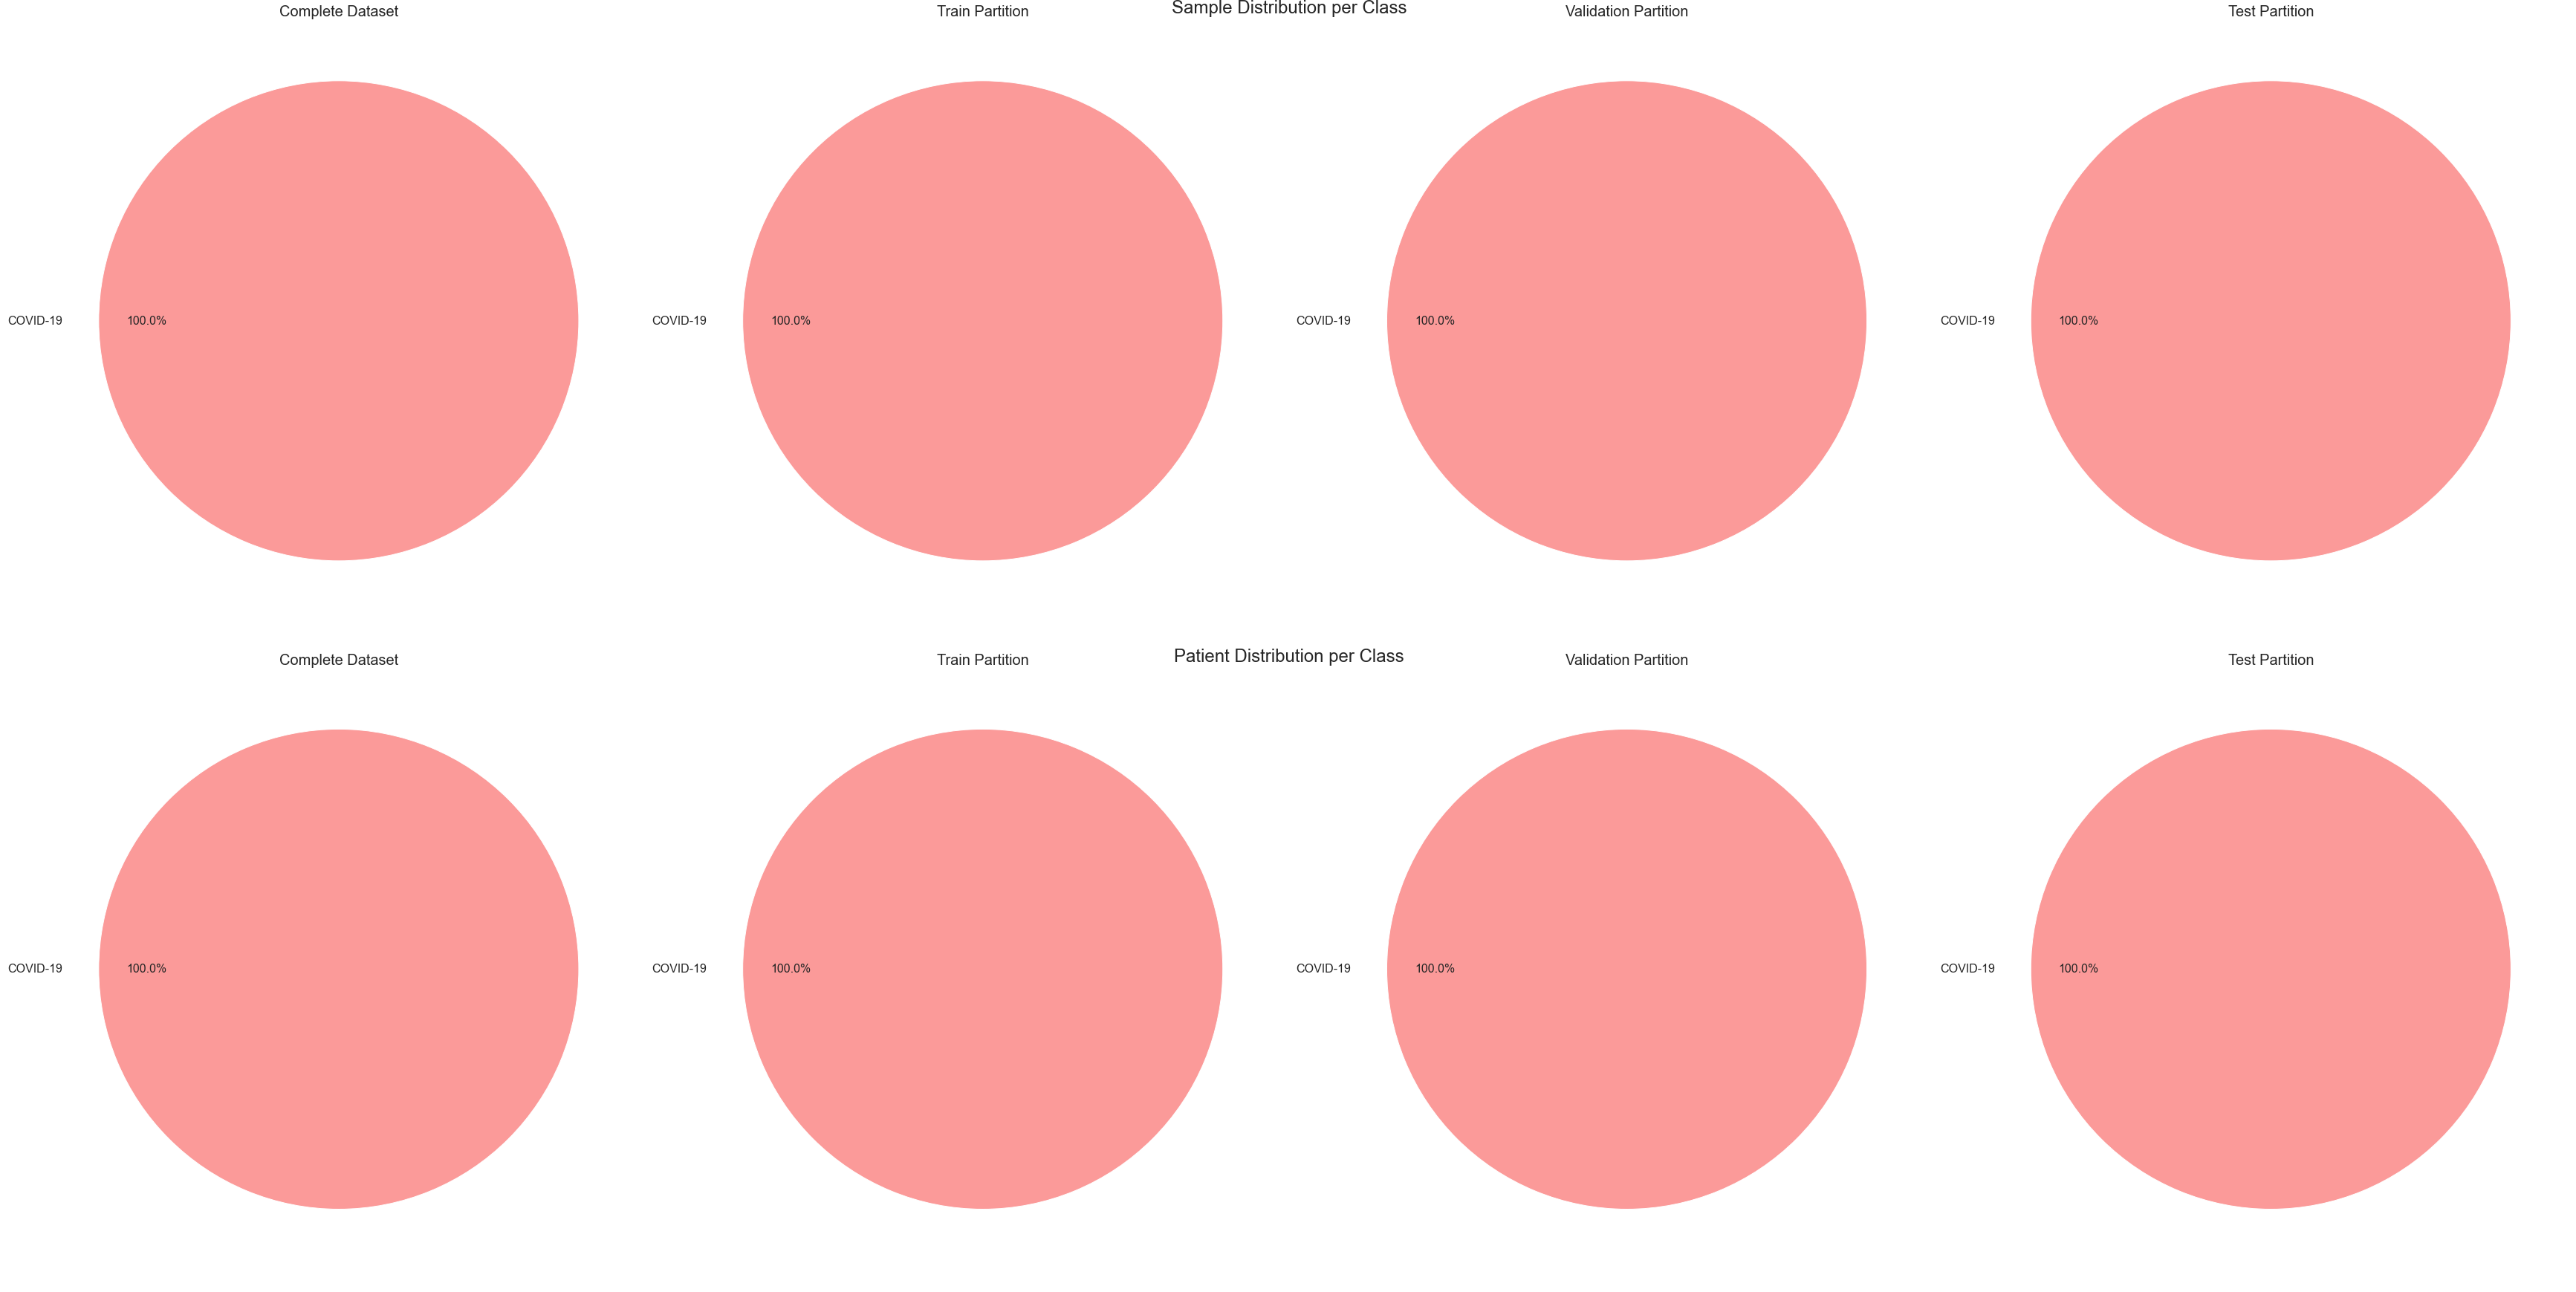

In [7]:
plot.column_as_pies( samples_df, patient_df, "class", dataset_name, figsize = (48, 24) )

In [8]:
plot.column_as_table( samples_df, patient_df, "class", dataset_name, bin_flag = False )

,Dataset,Train,Val,Test
Values,,,,
COVID-19,11816,10044,885,887
Normal,0,0,0,0
Pneumonia,0,0,0,0
SUM,11816,10044,885,887
,Dataset,Train,Val,Test
Values,,,,
COVID-19,643,553,49,41
Pneumonia,0,0,0,0
Normal,0,0,0,0


## Age

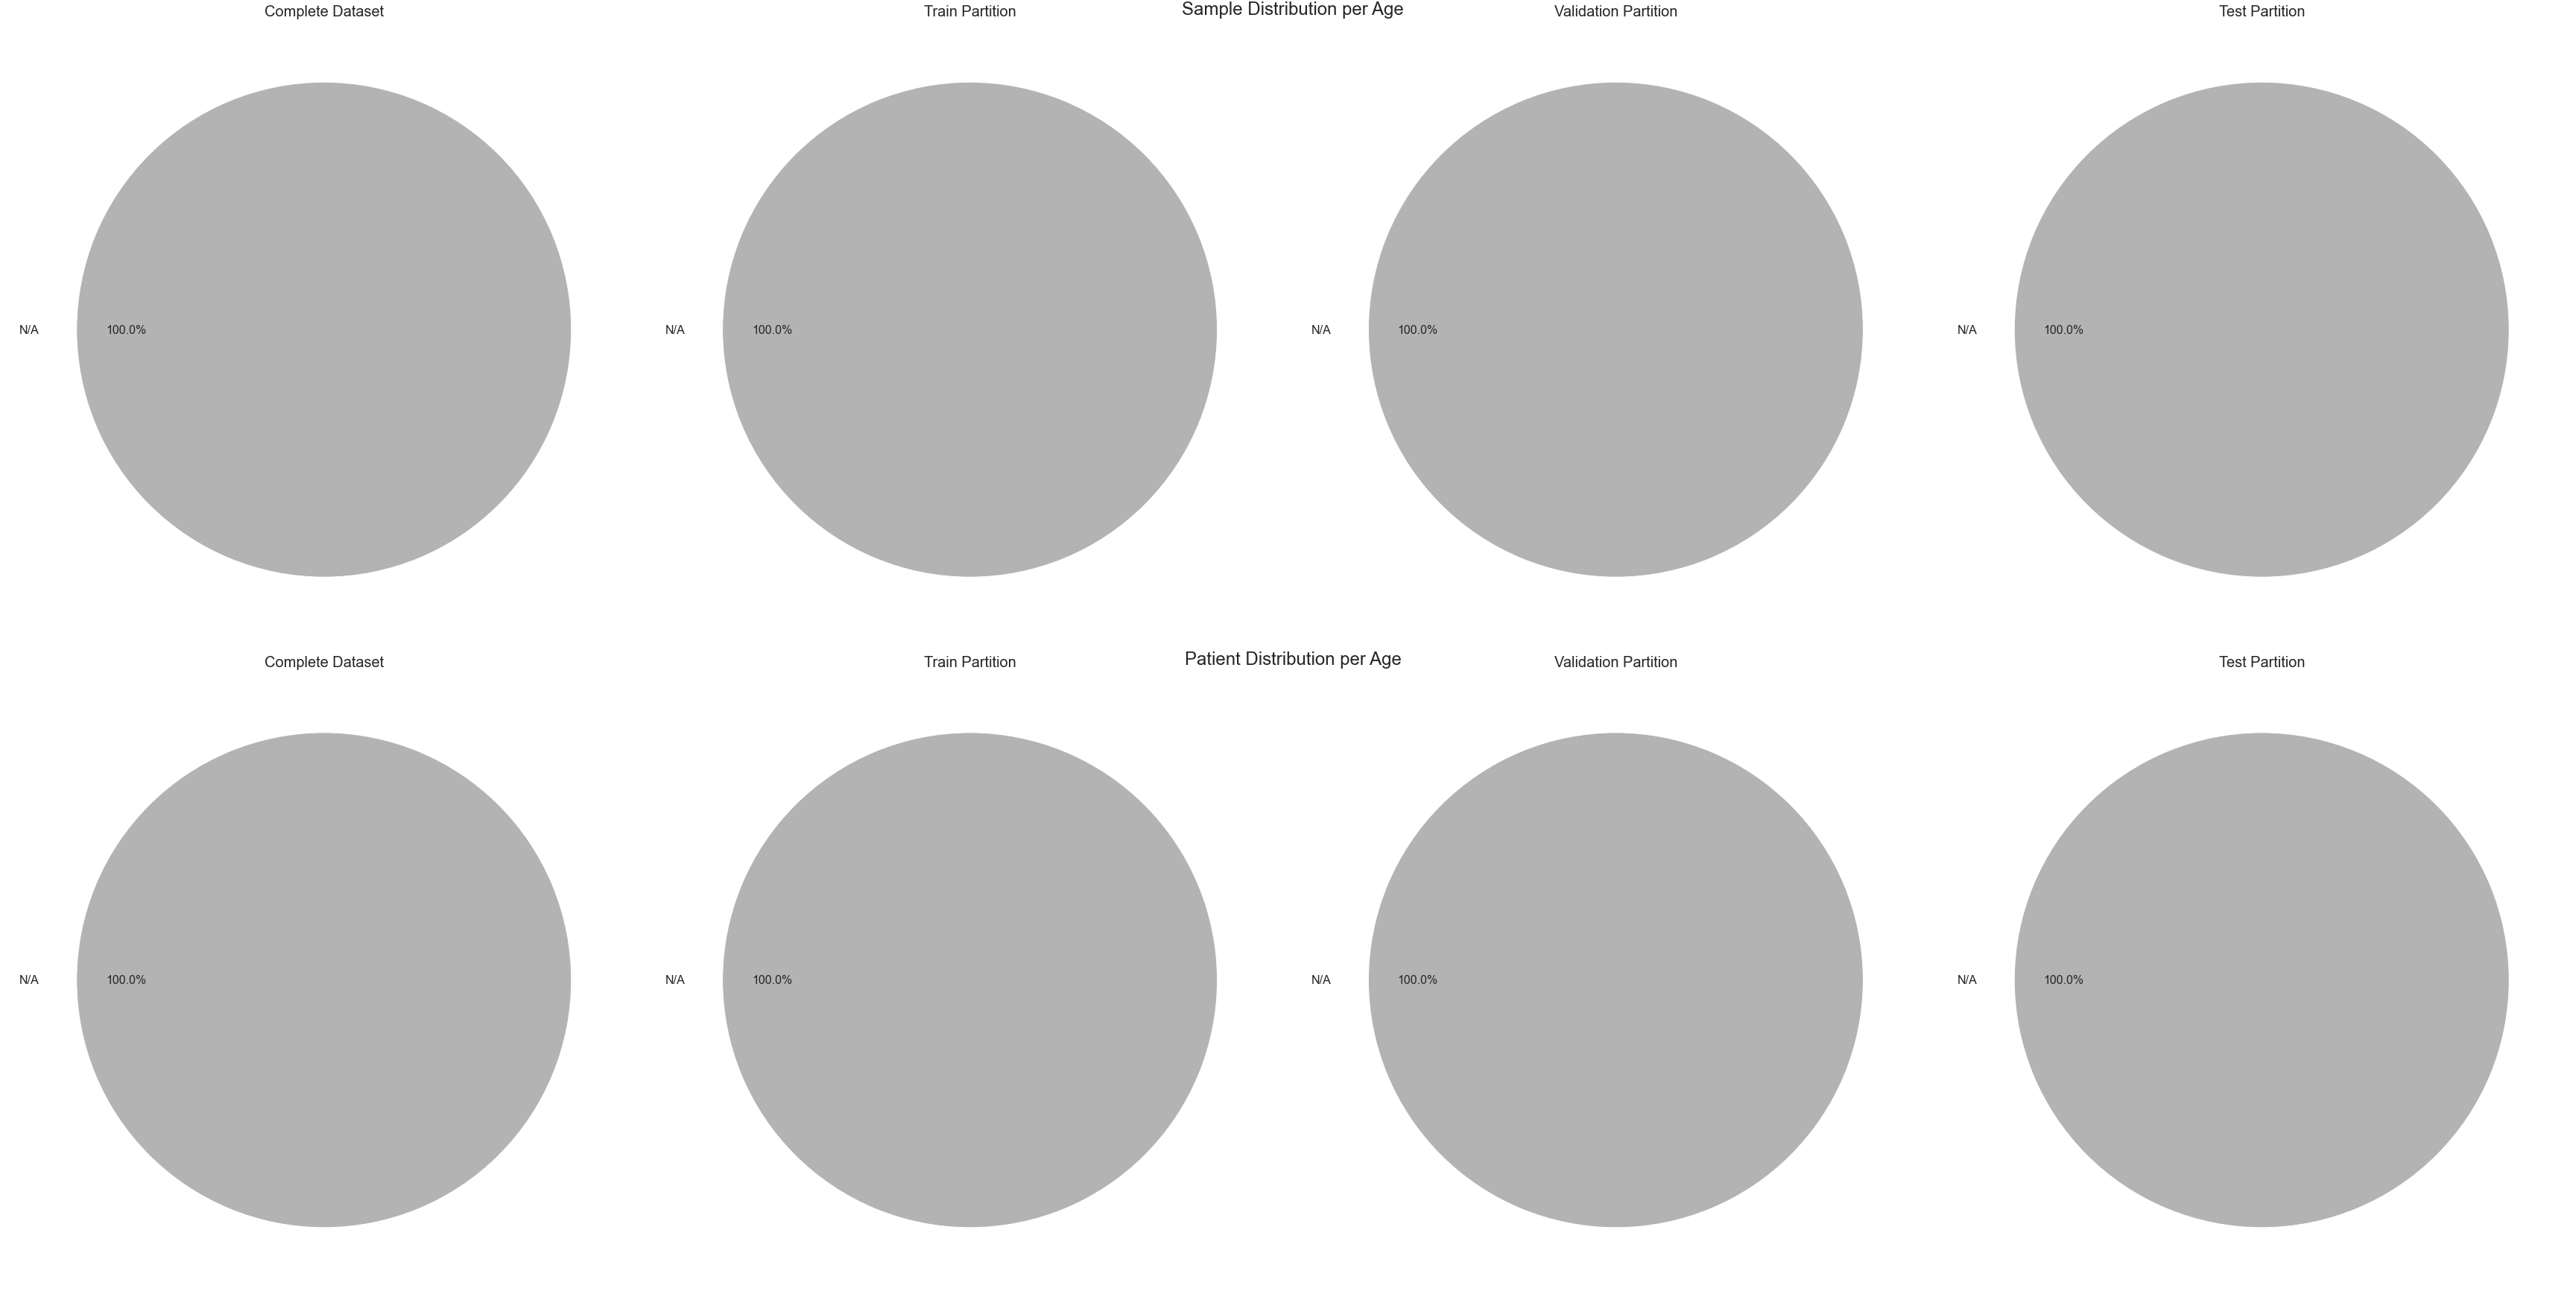

In [9]:
plot.column_as_pies( samples_df, patient_df, "age", dataset_name, figsize = (48, 24))

In [10]:
plot.column_as_table( samples_df, patient_df, "age", dataset_name, bin_flag = False )

,Dataset,Train,Val,Test
Values,,,,
N/A,11816,10044,885,887
Known Ages,0,0,0,0
SUM,11816,10044,885,887
,Dataset,Train,Val,Test
Values,,,,
N/A,643,553,49,41
Known Ages,0,0,0,0
SUM,643,553,49,41


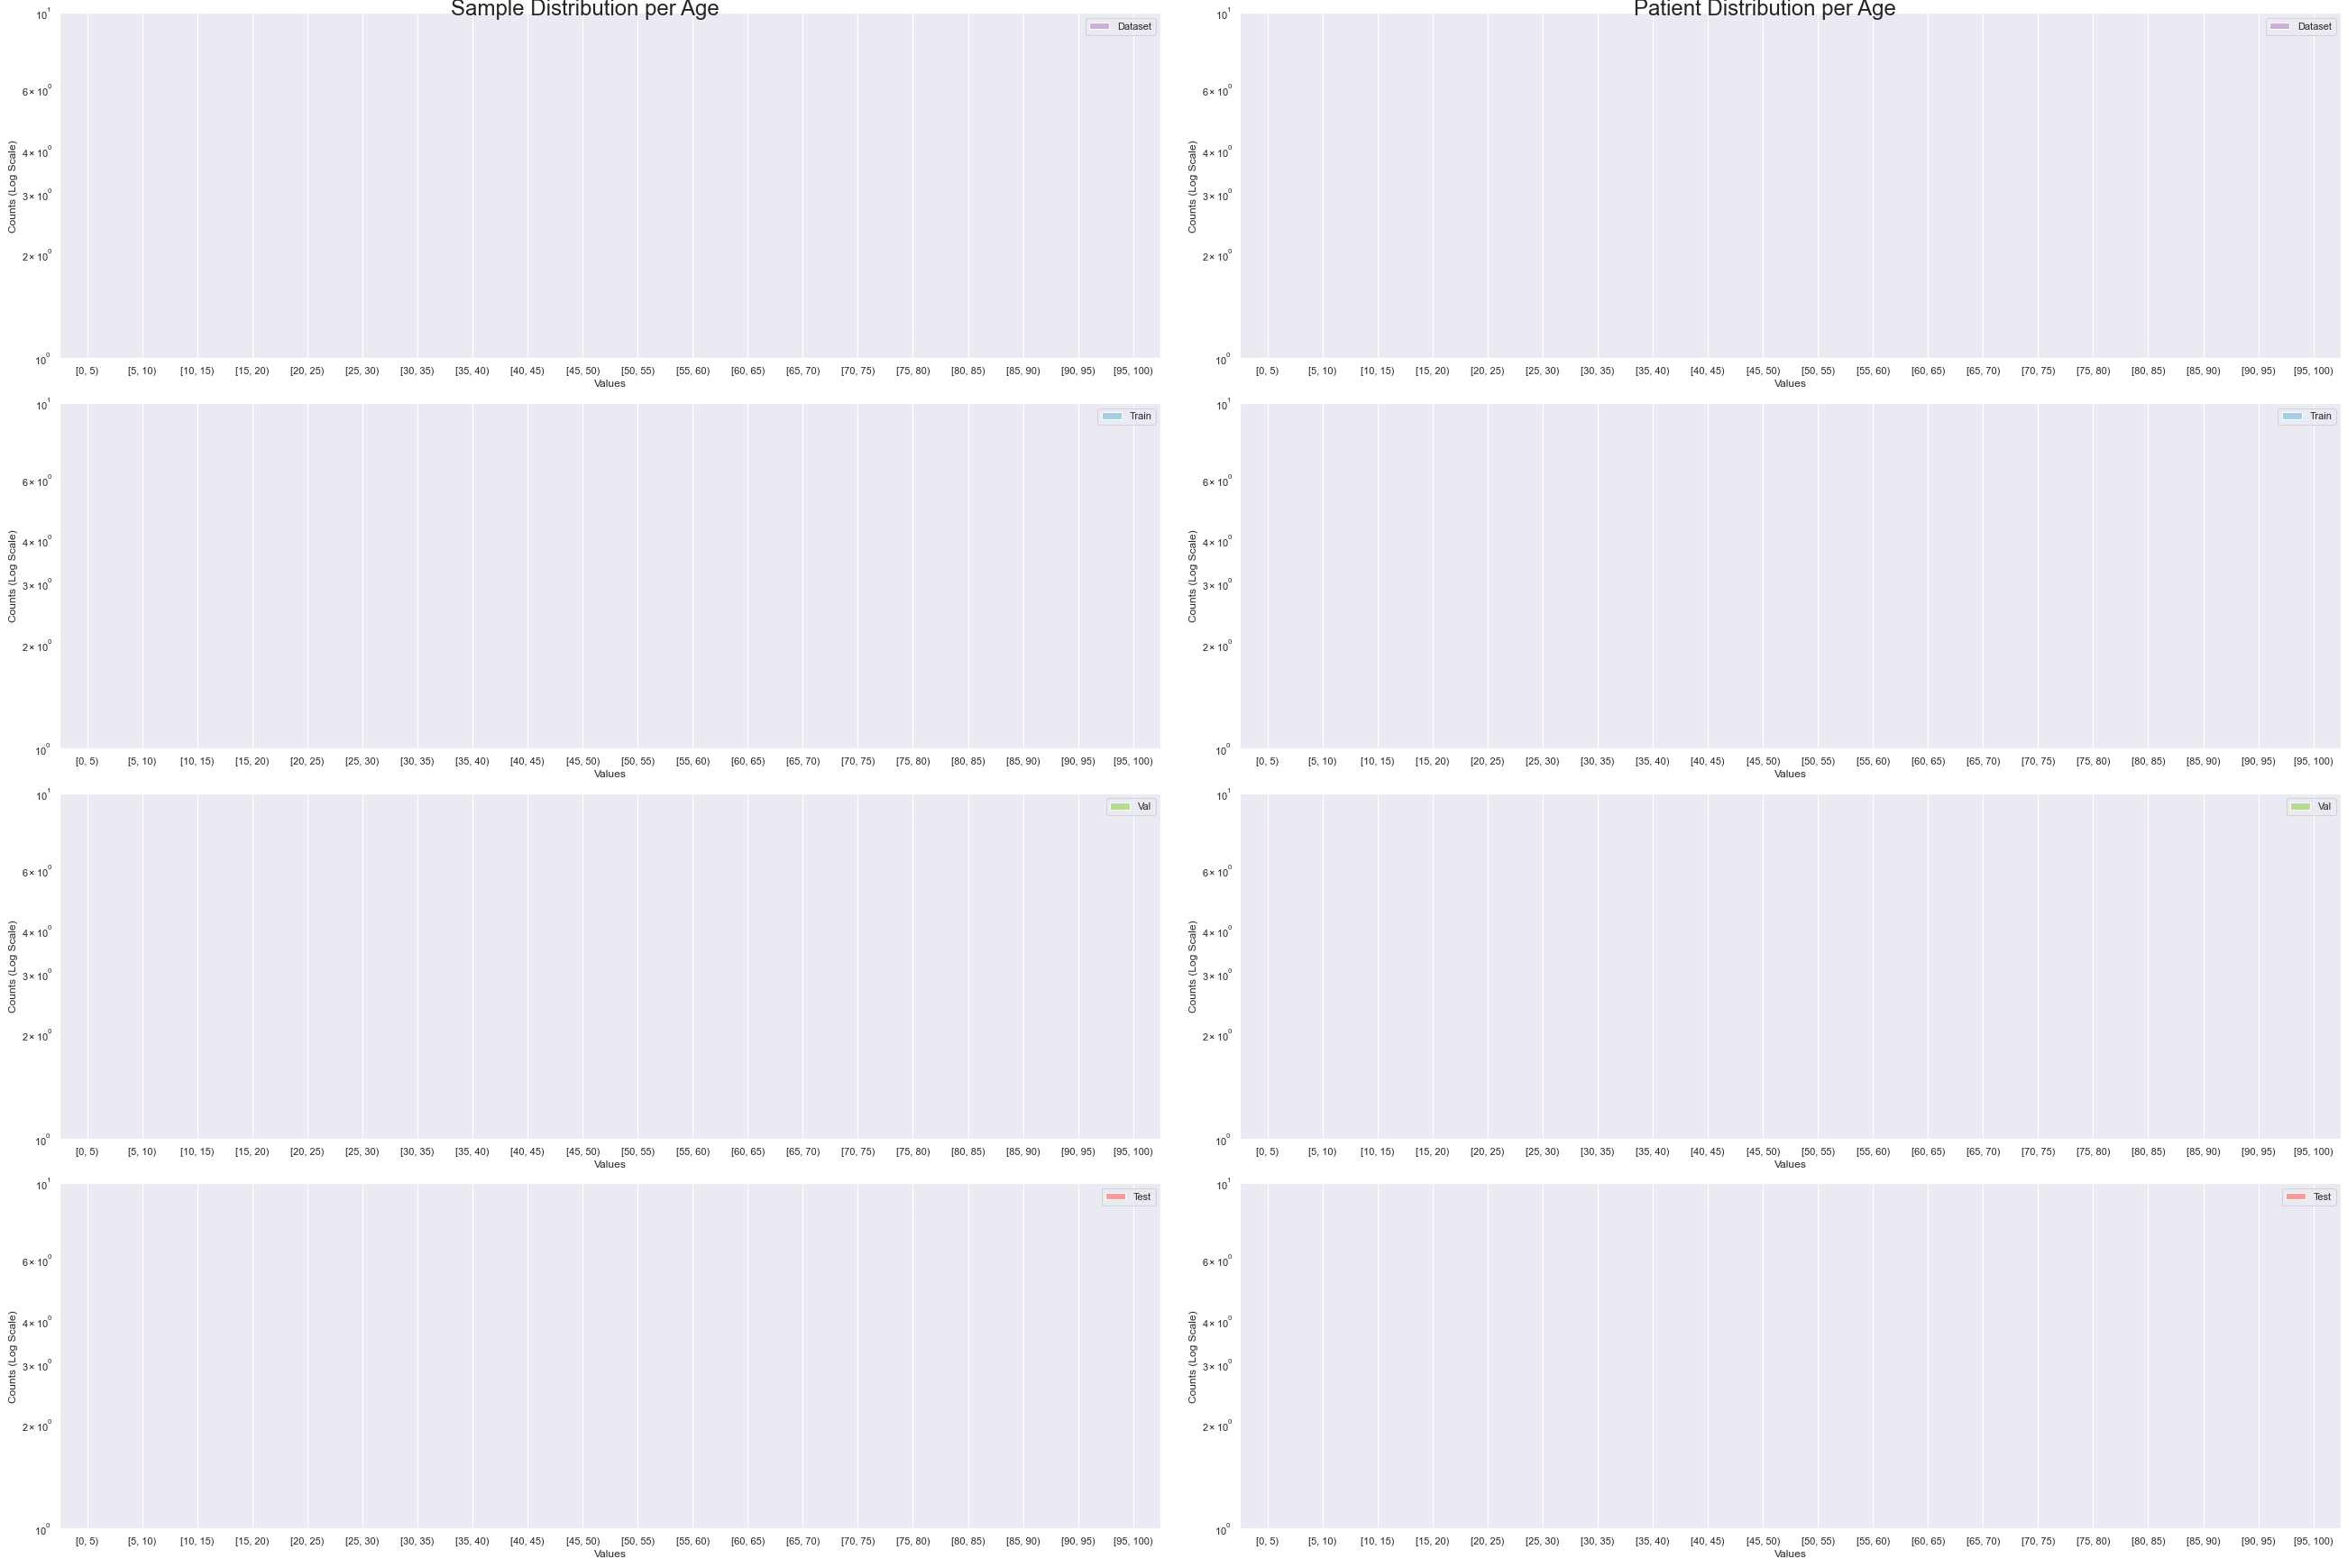

In [11]:
plot.column_as_histograms( samples_df, patient_df, "age", dataset_name, figsize = (36, 24))

In [12]:
plot.column_as_table( samples_df, patient_df, "age", dataset_name, bin_flag = True )

,Dataset,Train,Val,Test
Values,,,,
"[0, 5)",0,0,0,0
"[5, 10)",0,0,0,0
"[10, 15)",0,0,0,0
"[15, 20)",0,0,0,0
"[20, 25)",0,0,0,0
"[25, 30)",0,0,0,0
"[30, 35)",0,0,0,0
"[35, 40)",0,0,0,0
"[40, 45)",0,0,0,0


## Sex

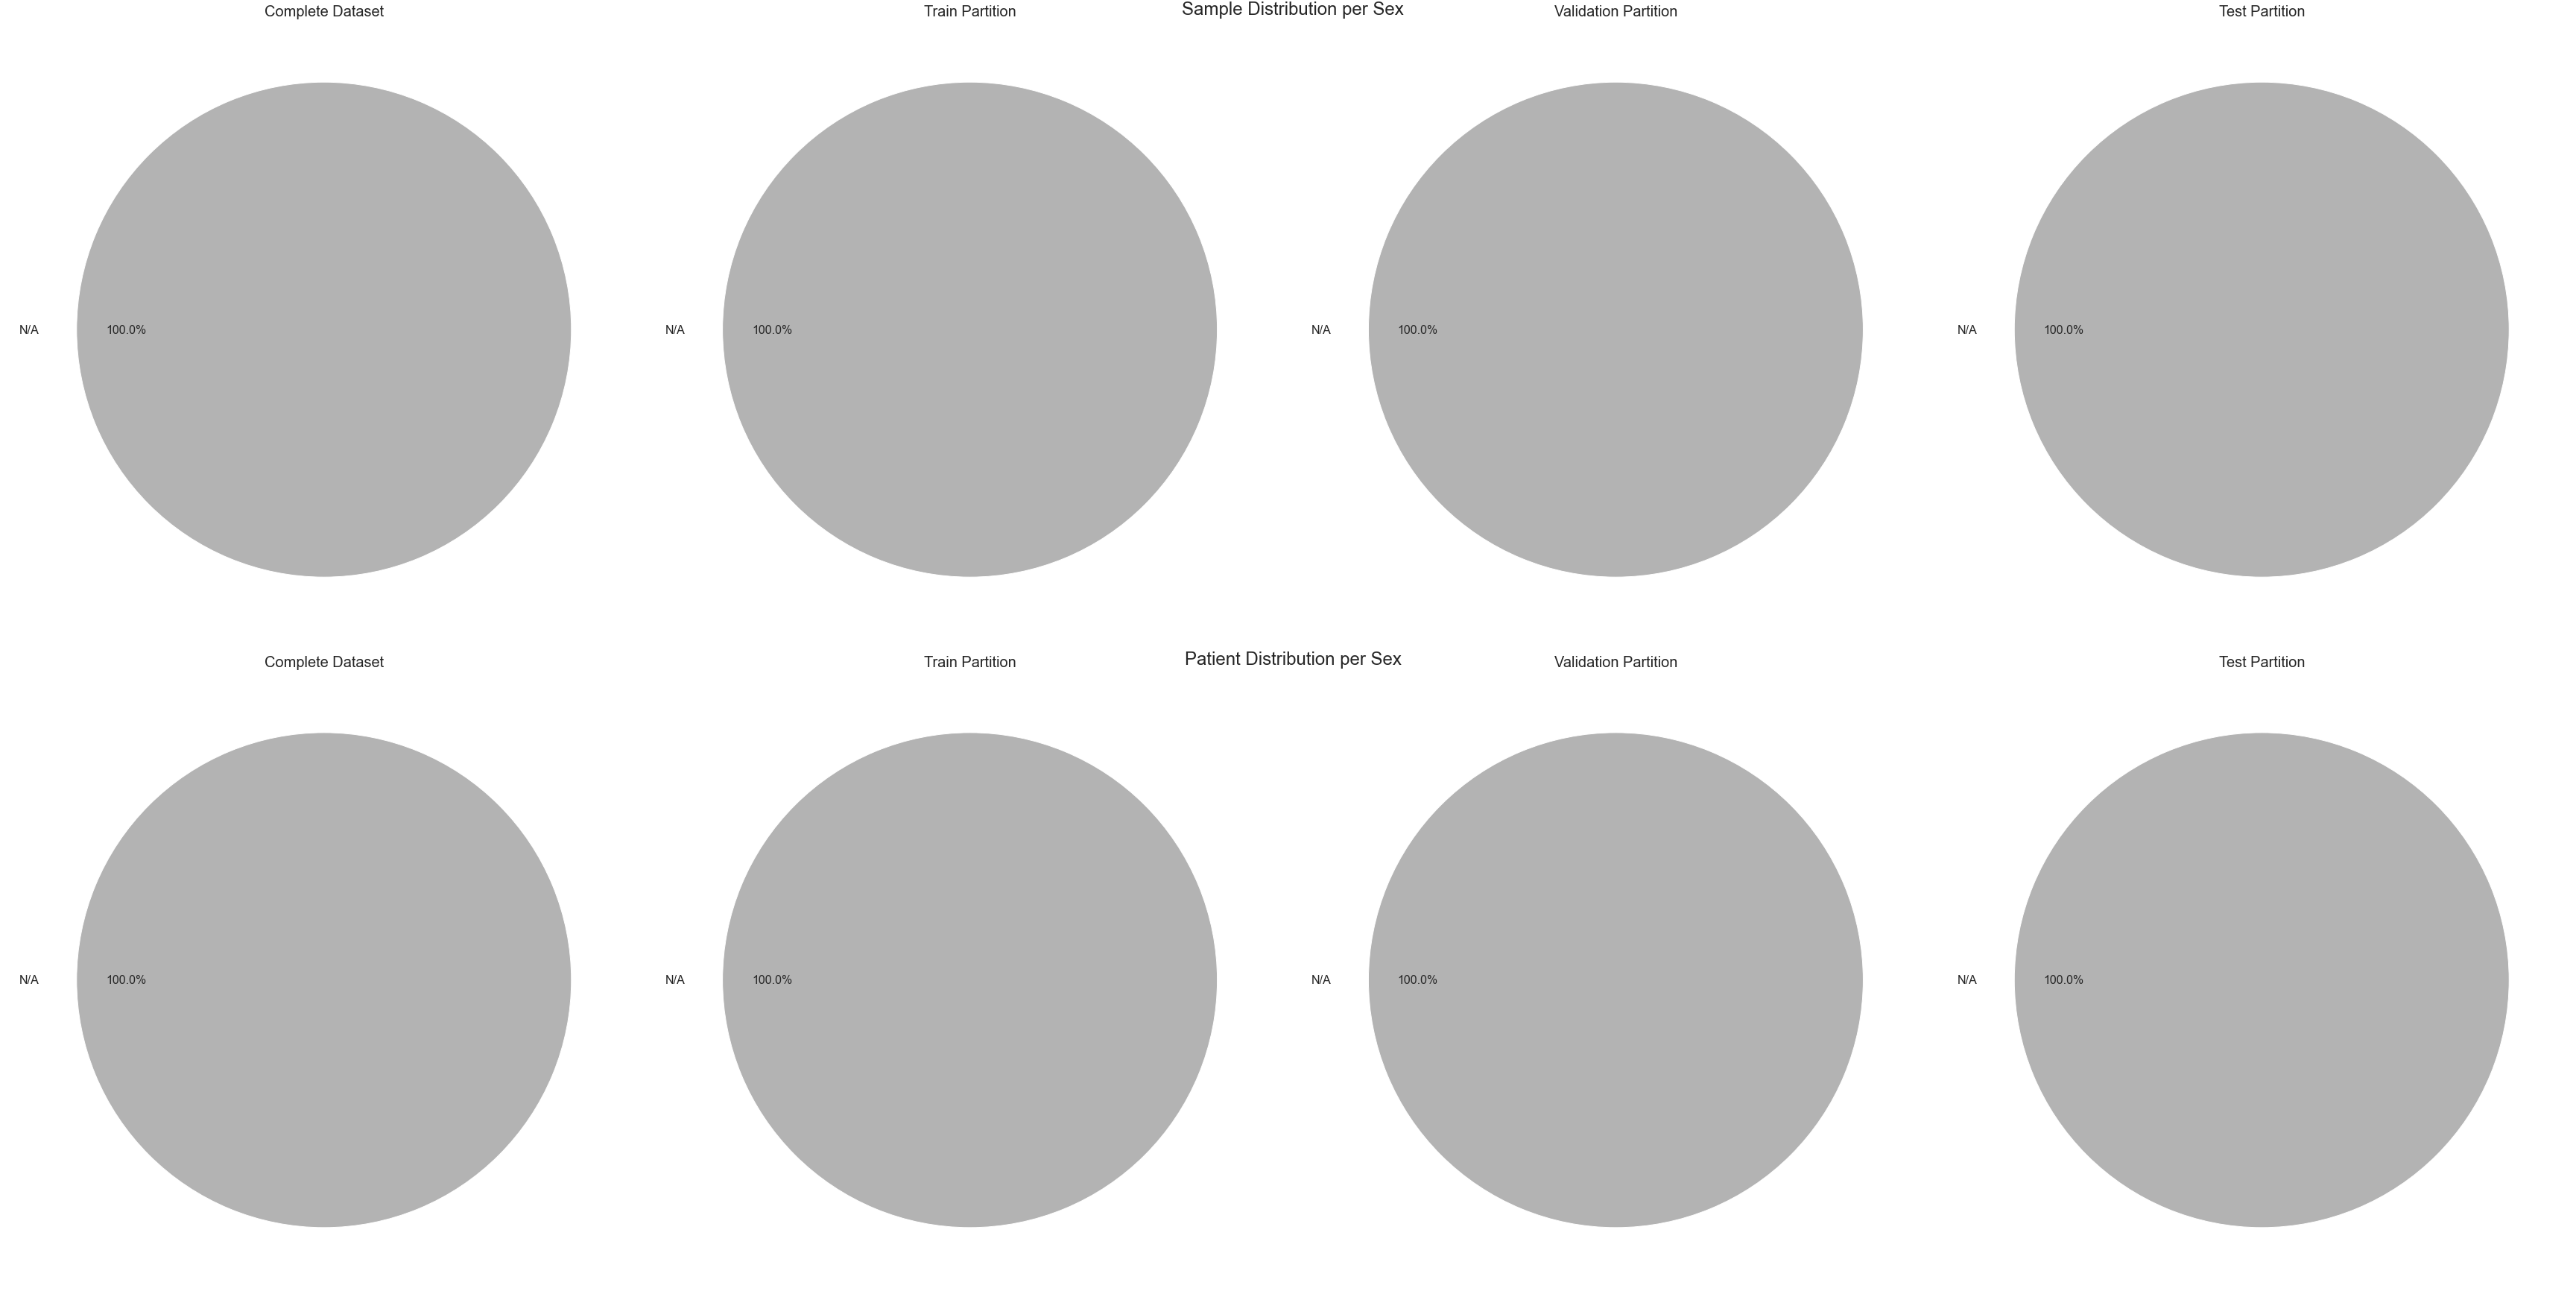

In [13]:
plot.column_as_pies( samples_df, patient_df, "sex", dataset_name, figsize = (48, 24) )

In [14]:
plot.column_as_table( samples_df, patient_df, "sex", dataset_name, bin_flag = False )

,Dataset,Train,Val,Test
Values,,,,
M,0,0,0,0
N/A,11816,10044,885,887
F,0,0,0,0
SUM,11816,10044,885,887
,Dataset,Train,Val,Test
Values,,,,
N/A,643,553,49,41
M,0,0,0,0
F,0,0,0,0


## Country

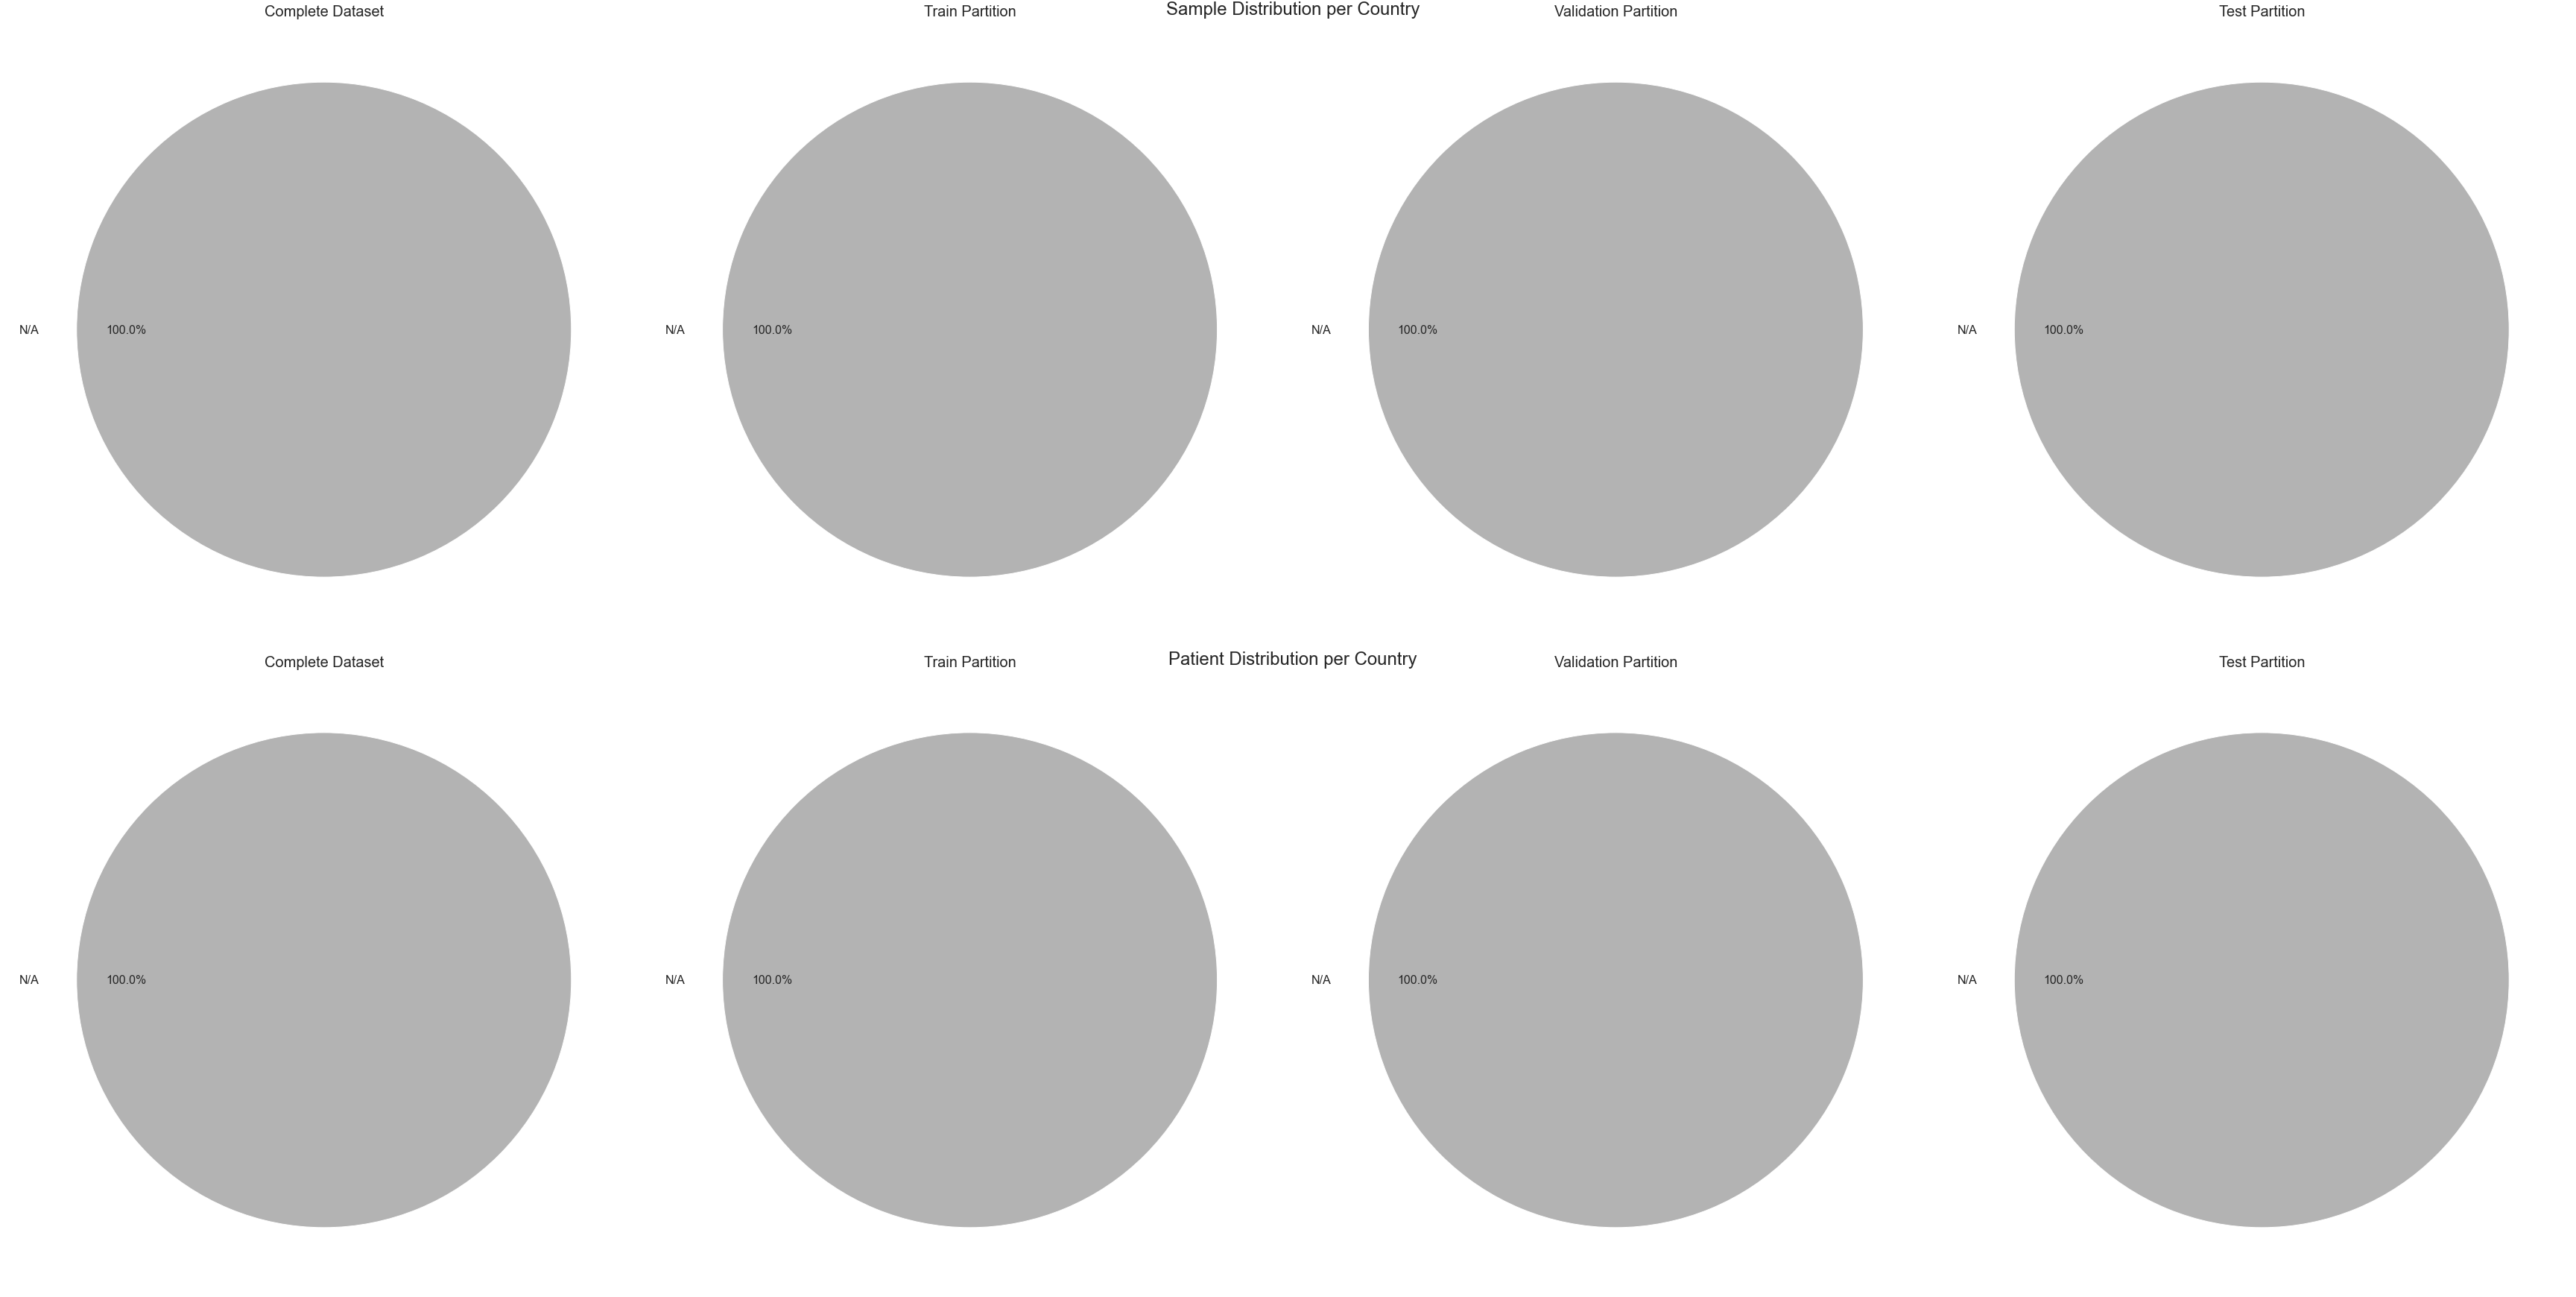

In [15]:
plot.column_as_pies( samples_df, patient_df, "country", dataset_name, figsize = (48, 24) )

In [16]:
plot.column_as_table( samples_df, patient_df, "country", dataset_name, bin_flag = False )

,Dataset,Train,Val,Test
Values,,,,
France,0,0,0,0
China,0,0,0,0
Iran,0,0,0,0
USA,0,0,0,0
N/A,11816,10044,885,887
Australia,0,0,0,0
Italy,0,0,0,0
Algeria,0,0,0,0
Belgium,0,0,0,0


## Partition

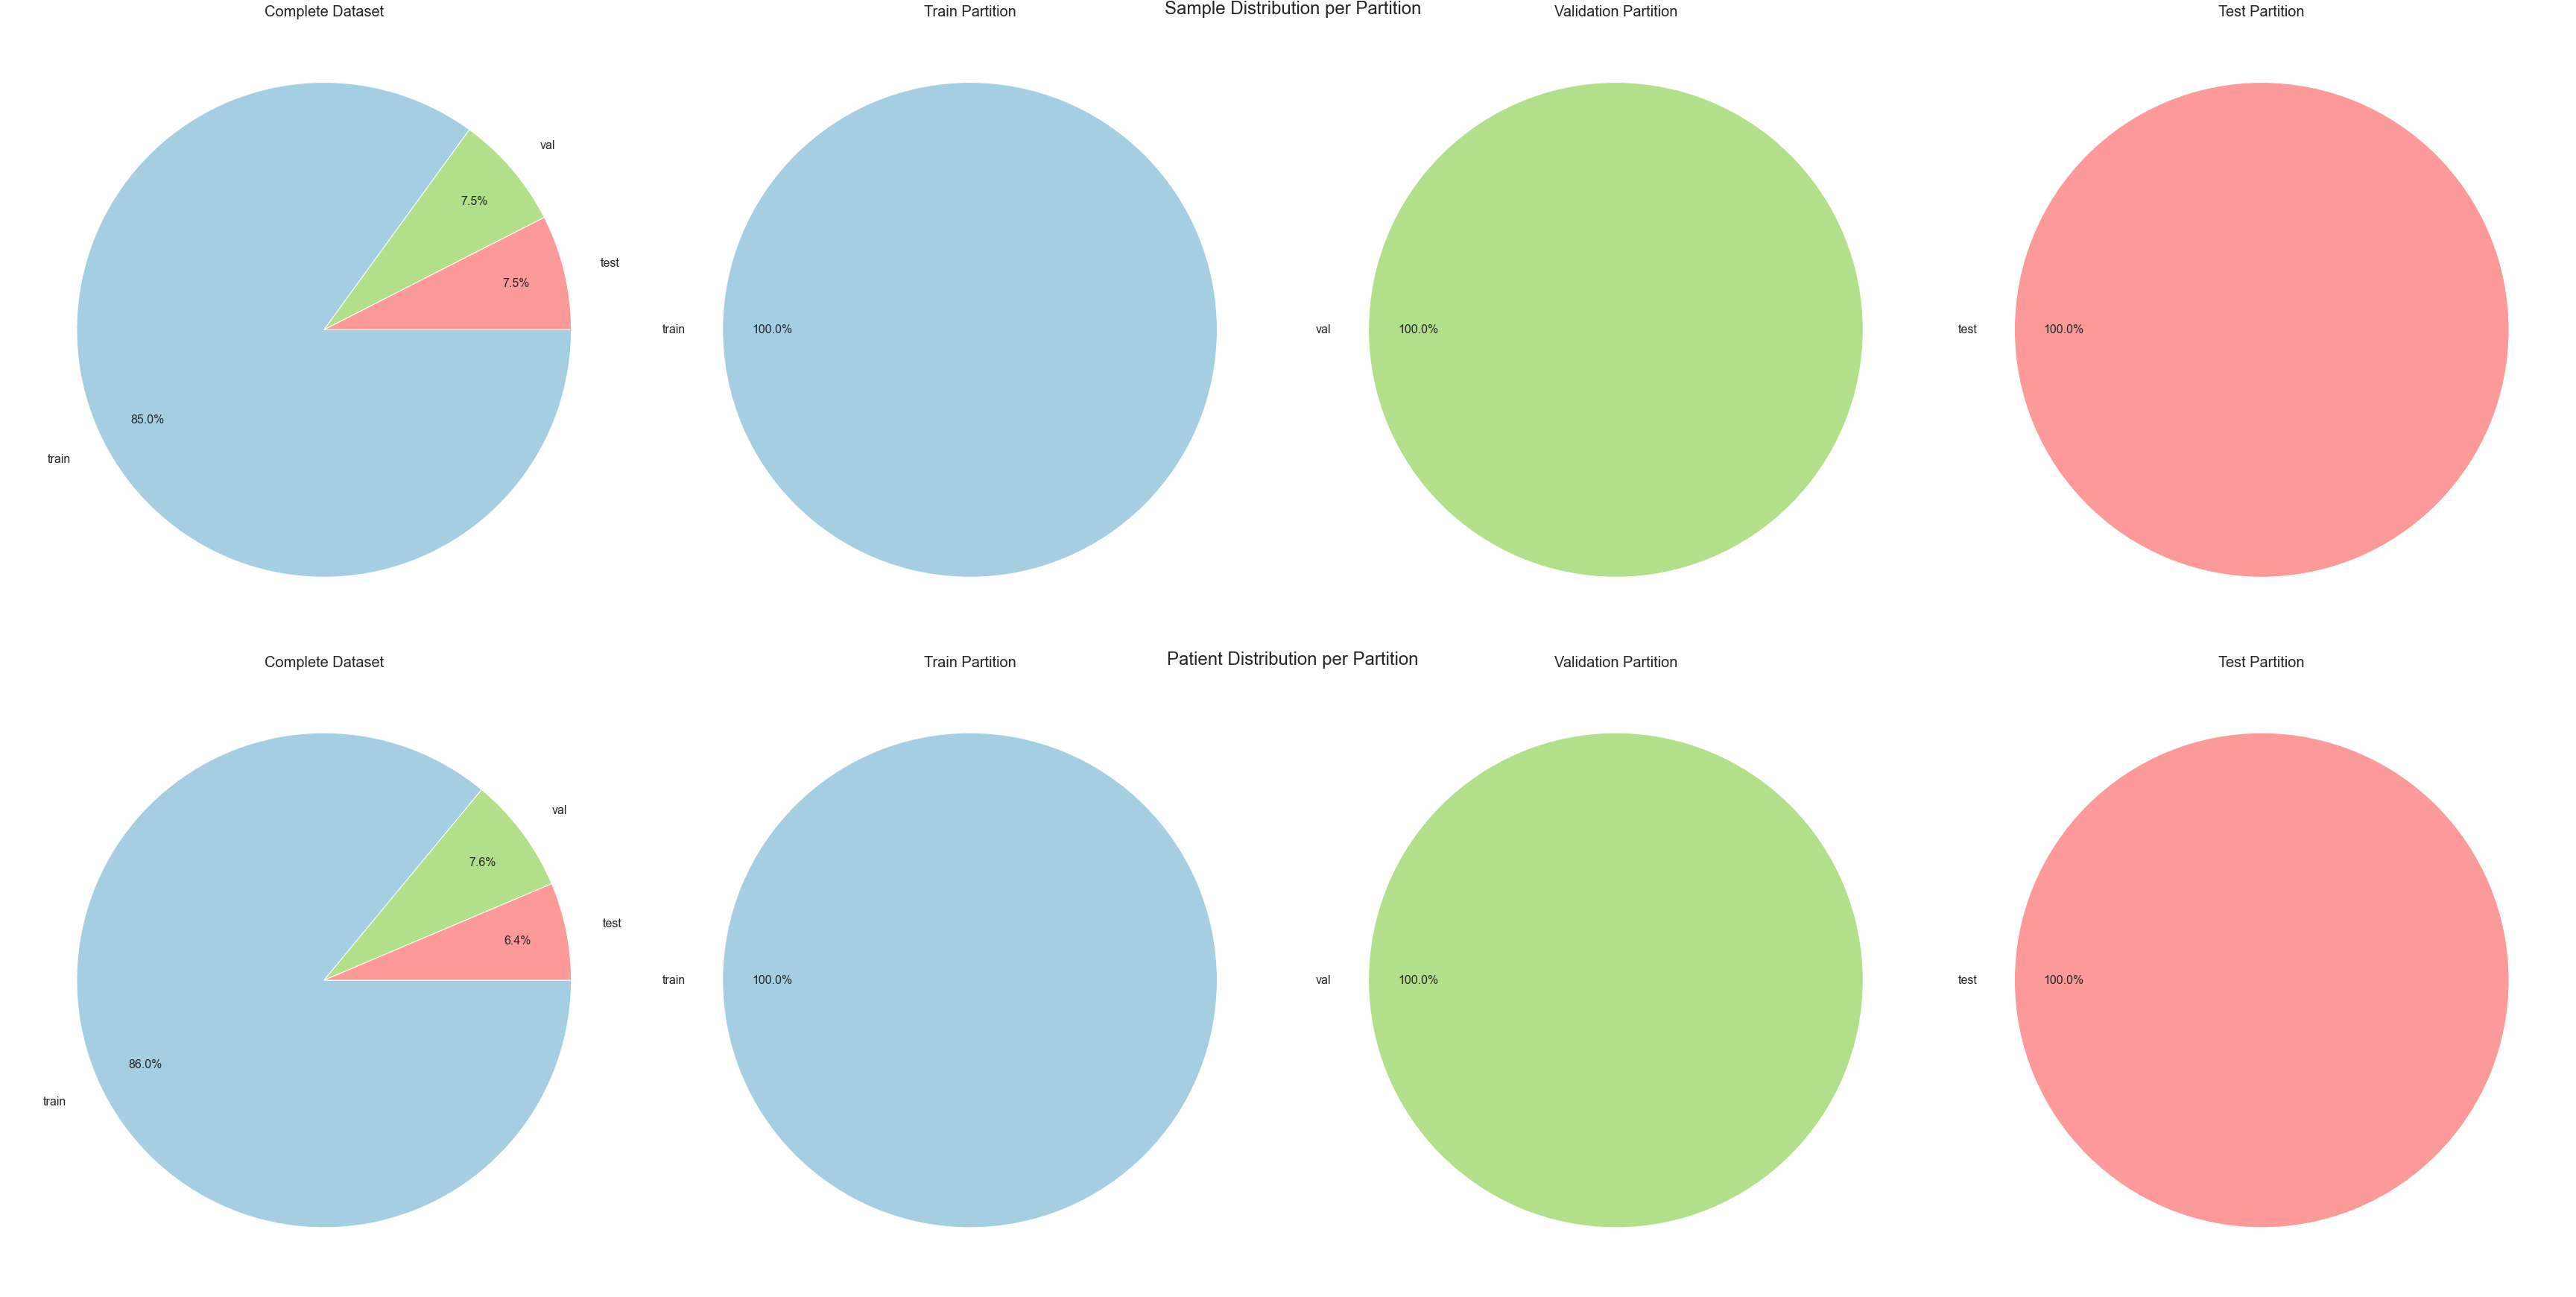

In [17]:
plot.column_as_pies( samples_df, patient_df, "partition", dataset_name, figsize = (48, 24) )

In [18]:
plot.column_as_table( samples_df, patient_df, "partition", dataset_name, bin_flag = False )

,Dataset,Train,Val,Test
Values,,,,
train,10044,10044,0,0
test,887,0,0,887
val,885,0,885,0
SUM,11816,10044,885,887
,Dataset,Train,Val,Test
Values,,,,
train,553,553,0,0
val,49,0,49,0
test,41,0,0,41


## Slice Selection

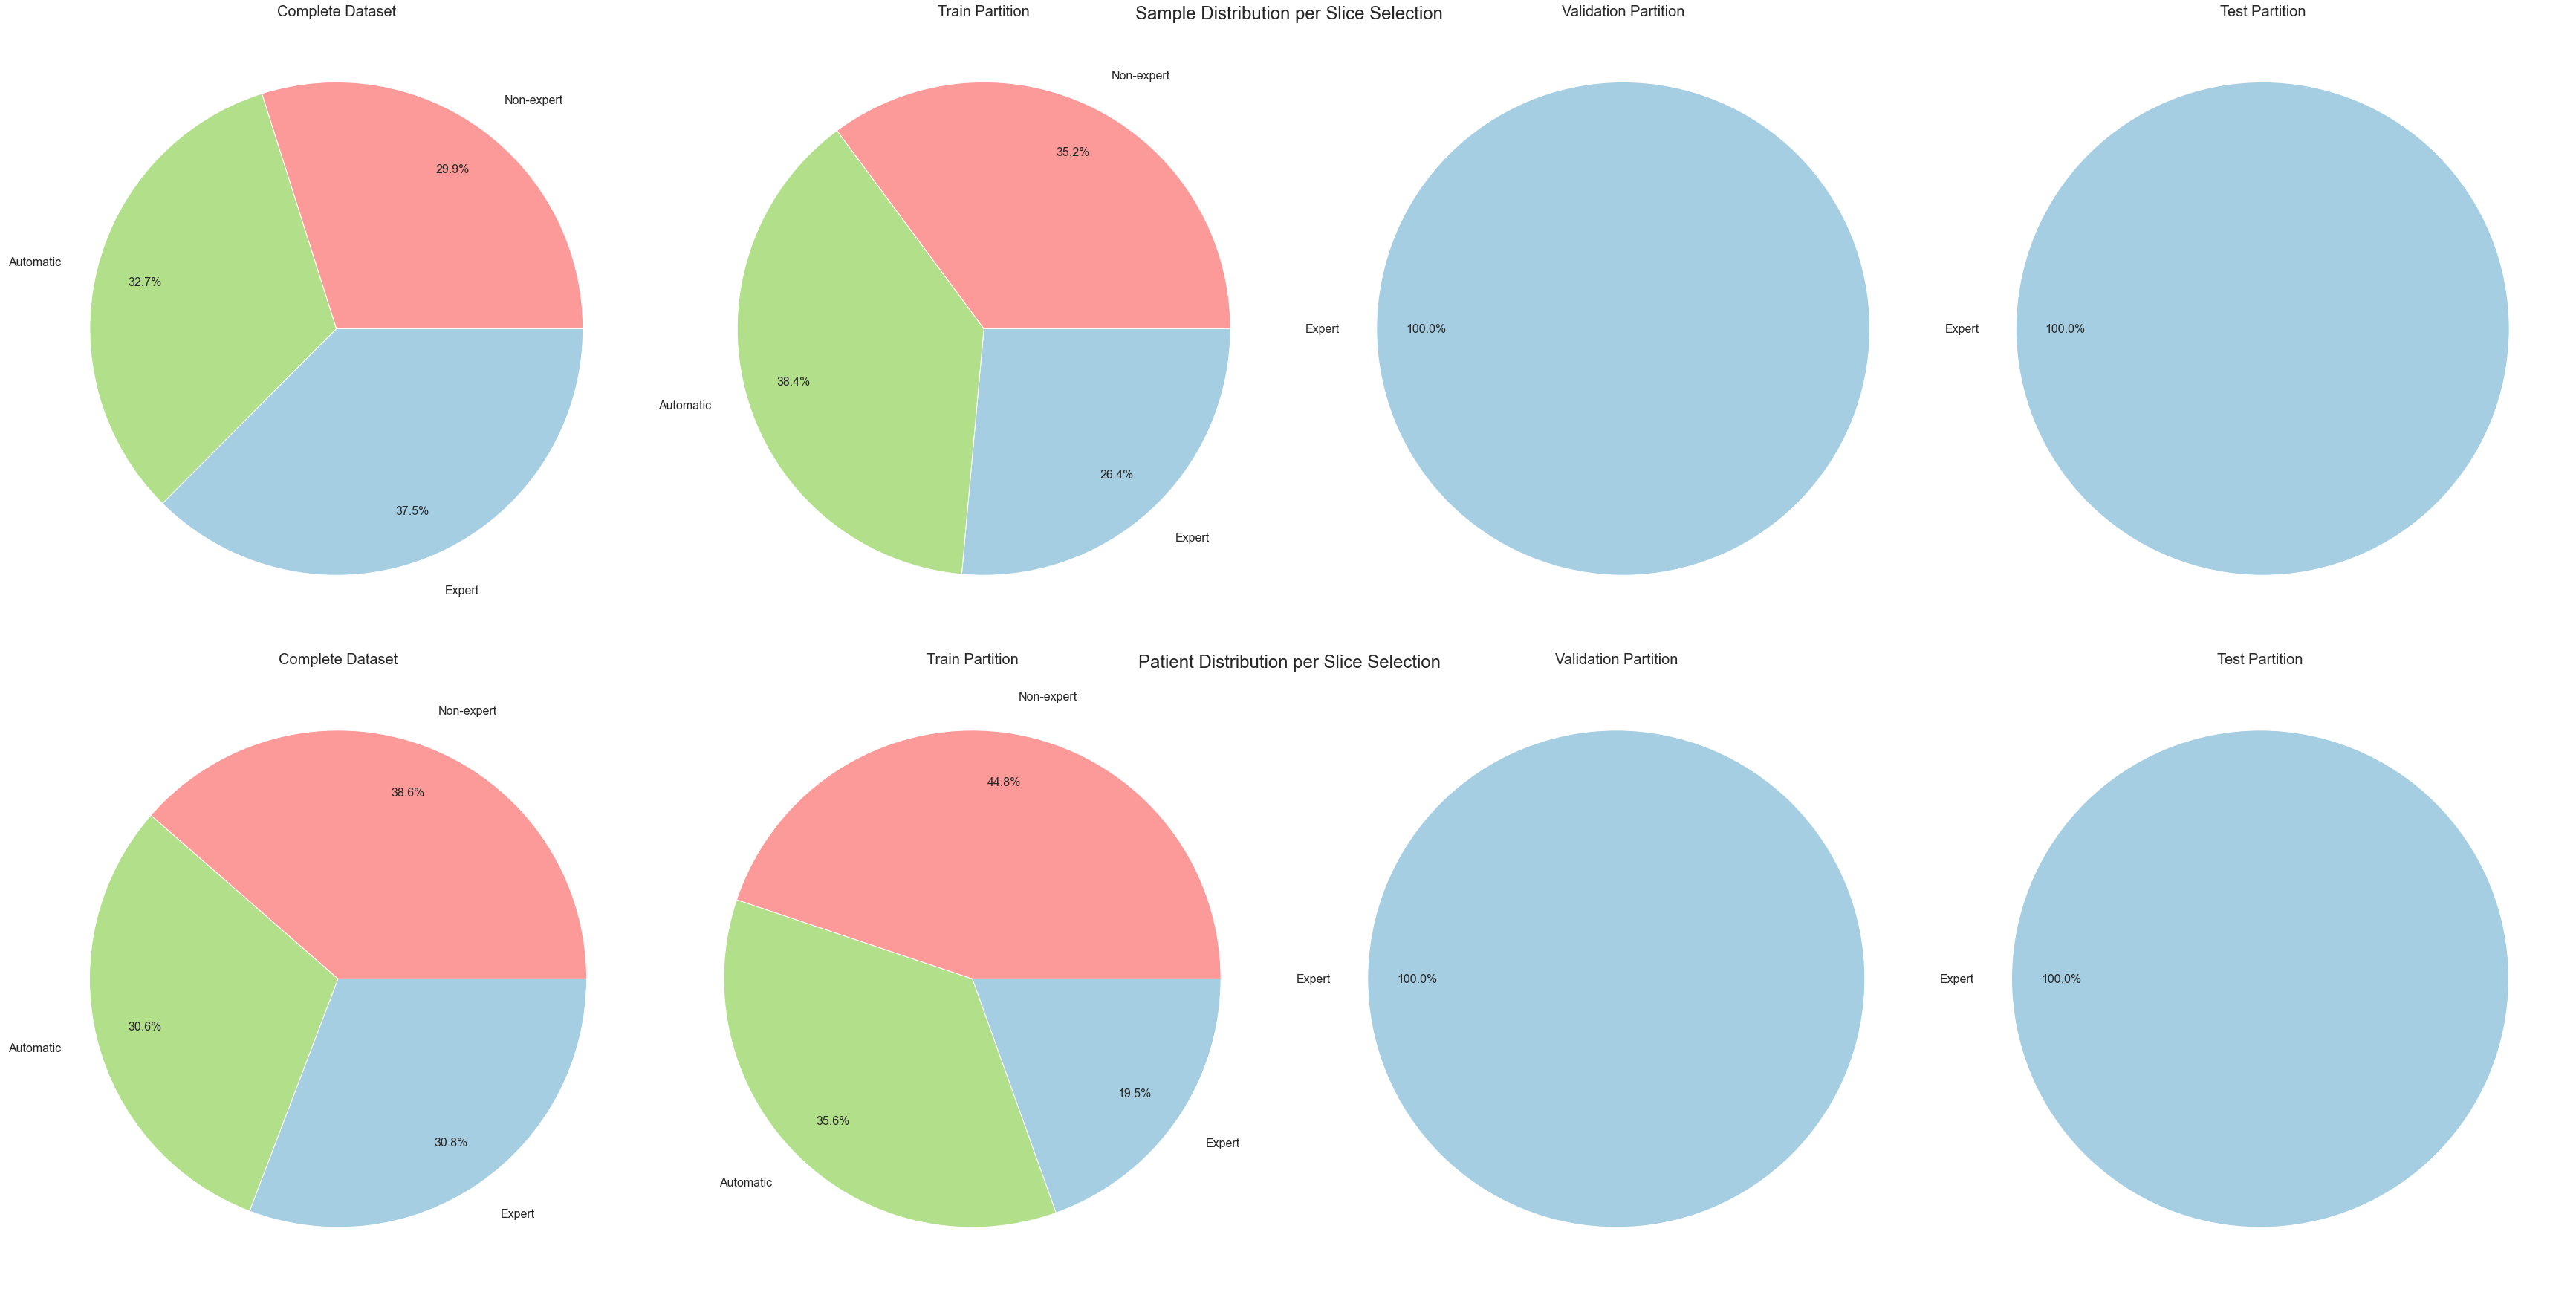

In [19]:
plot.column_as_pies( samples_df, patient_df, "slice_selection", dataset_name, figsize = (48, 24) )

In [20]:
plot.column_as_table( samples_df, patient_df, "slice_selection", dataset_name, bin_flag = False )

,Dataset,Train,Val,Test
Values,,,,
Automatic,3858,3858,0,0
Expert,4427,2655,885,887
N/A,0,0,0,0
Non-expert,3531,3531,0,0
SUM,11816,10044,885,887
,Dataset,Train,Val,Test
Values,,,,
Automatic,197,197,0,0
Expert,198,108,49,41


# Data Split

In [21]:
new_samples_df, new_patient_df = split.dataset_by_samples( samples_df, patient_df, dataset_name, seed = 1 )

    1/3: Group ('N/A', 'COVID-19', 'Expert', 'N/A', 'N/A')
	[Test] Moved 884 samples (39 patients), expected 885 samples, had 4427 samples (198 patients)...
		List of sample counts: [22, 27, 17, 26, 26, 25, 14, 14, 32, 27, 7, 30, 22, 29, 15, 13, 19, 15, 5, 21, 18, 8, 34, 12, 7, 96, 40, 35, 32, 23, 6, 5, 30, 30, 10, 12, 37, 15, 28, 30, 38, 17, 31, 7, 3, 21, 62, 44, 19, 15, 6, 40, 37, 26, 6, 33, 32, 11, 7, 44, 31, 36, 23, 7, 2, 6, 21, 11, 20, 121, 5, 35, 11, 9, 15, 33, 7, 11, 23, 4, 10, 11, 13, 7, 18, 32, 31, 27, 25, 11, 38, 101, 34, 14, 28, 39, 7, 38, 10, 22, 28, 25, 14, 112, 12, 2, 10, 20, 12, 16, 38, 11, 37, 29, 5, 49, 40, 16, 31, 35, 4, 9, 7, 8, 42, 2, 24, 14, 9, 17, 9, 9, 20, 38, 16, 35, 18, 29, 9, 12, 6, 10, 22, 20, 24, 35, 19, 19, 24, 10, 25, 29, 34, 17, 23, 29, 28, 17, 13, 16, 4, 13, 14, 12, 5, 19, 4, 19, 26, 23, 30, 21, 22, 41, 43, 35, 30, 16, 14, 22, 43, 29, 29, 13, 41, 13, 9, 29, 14, 4, 21, 33, 24, 3, 7, 18, 26, 5]
	[Val] Moved 884 samples (37 patients), expected 885 samples, 

# Post Split Plots

## Class

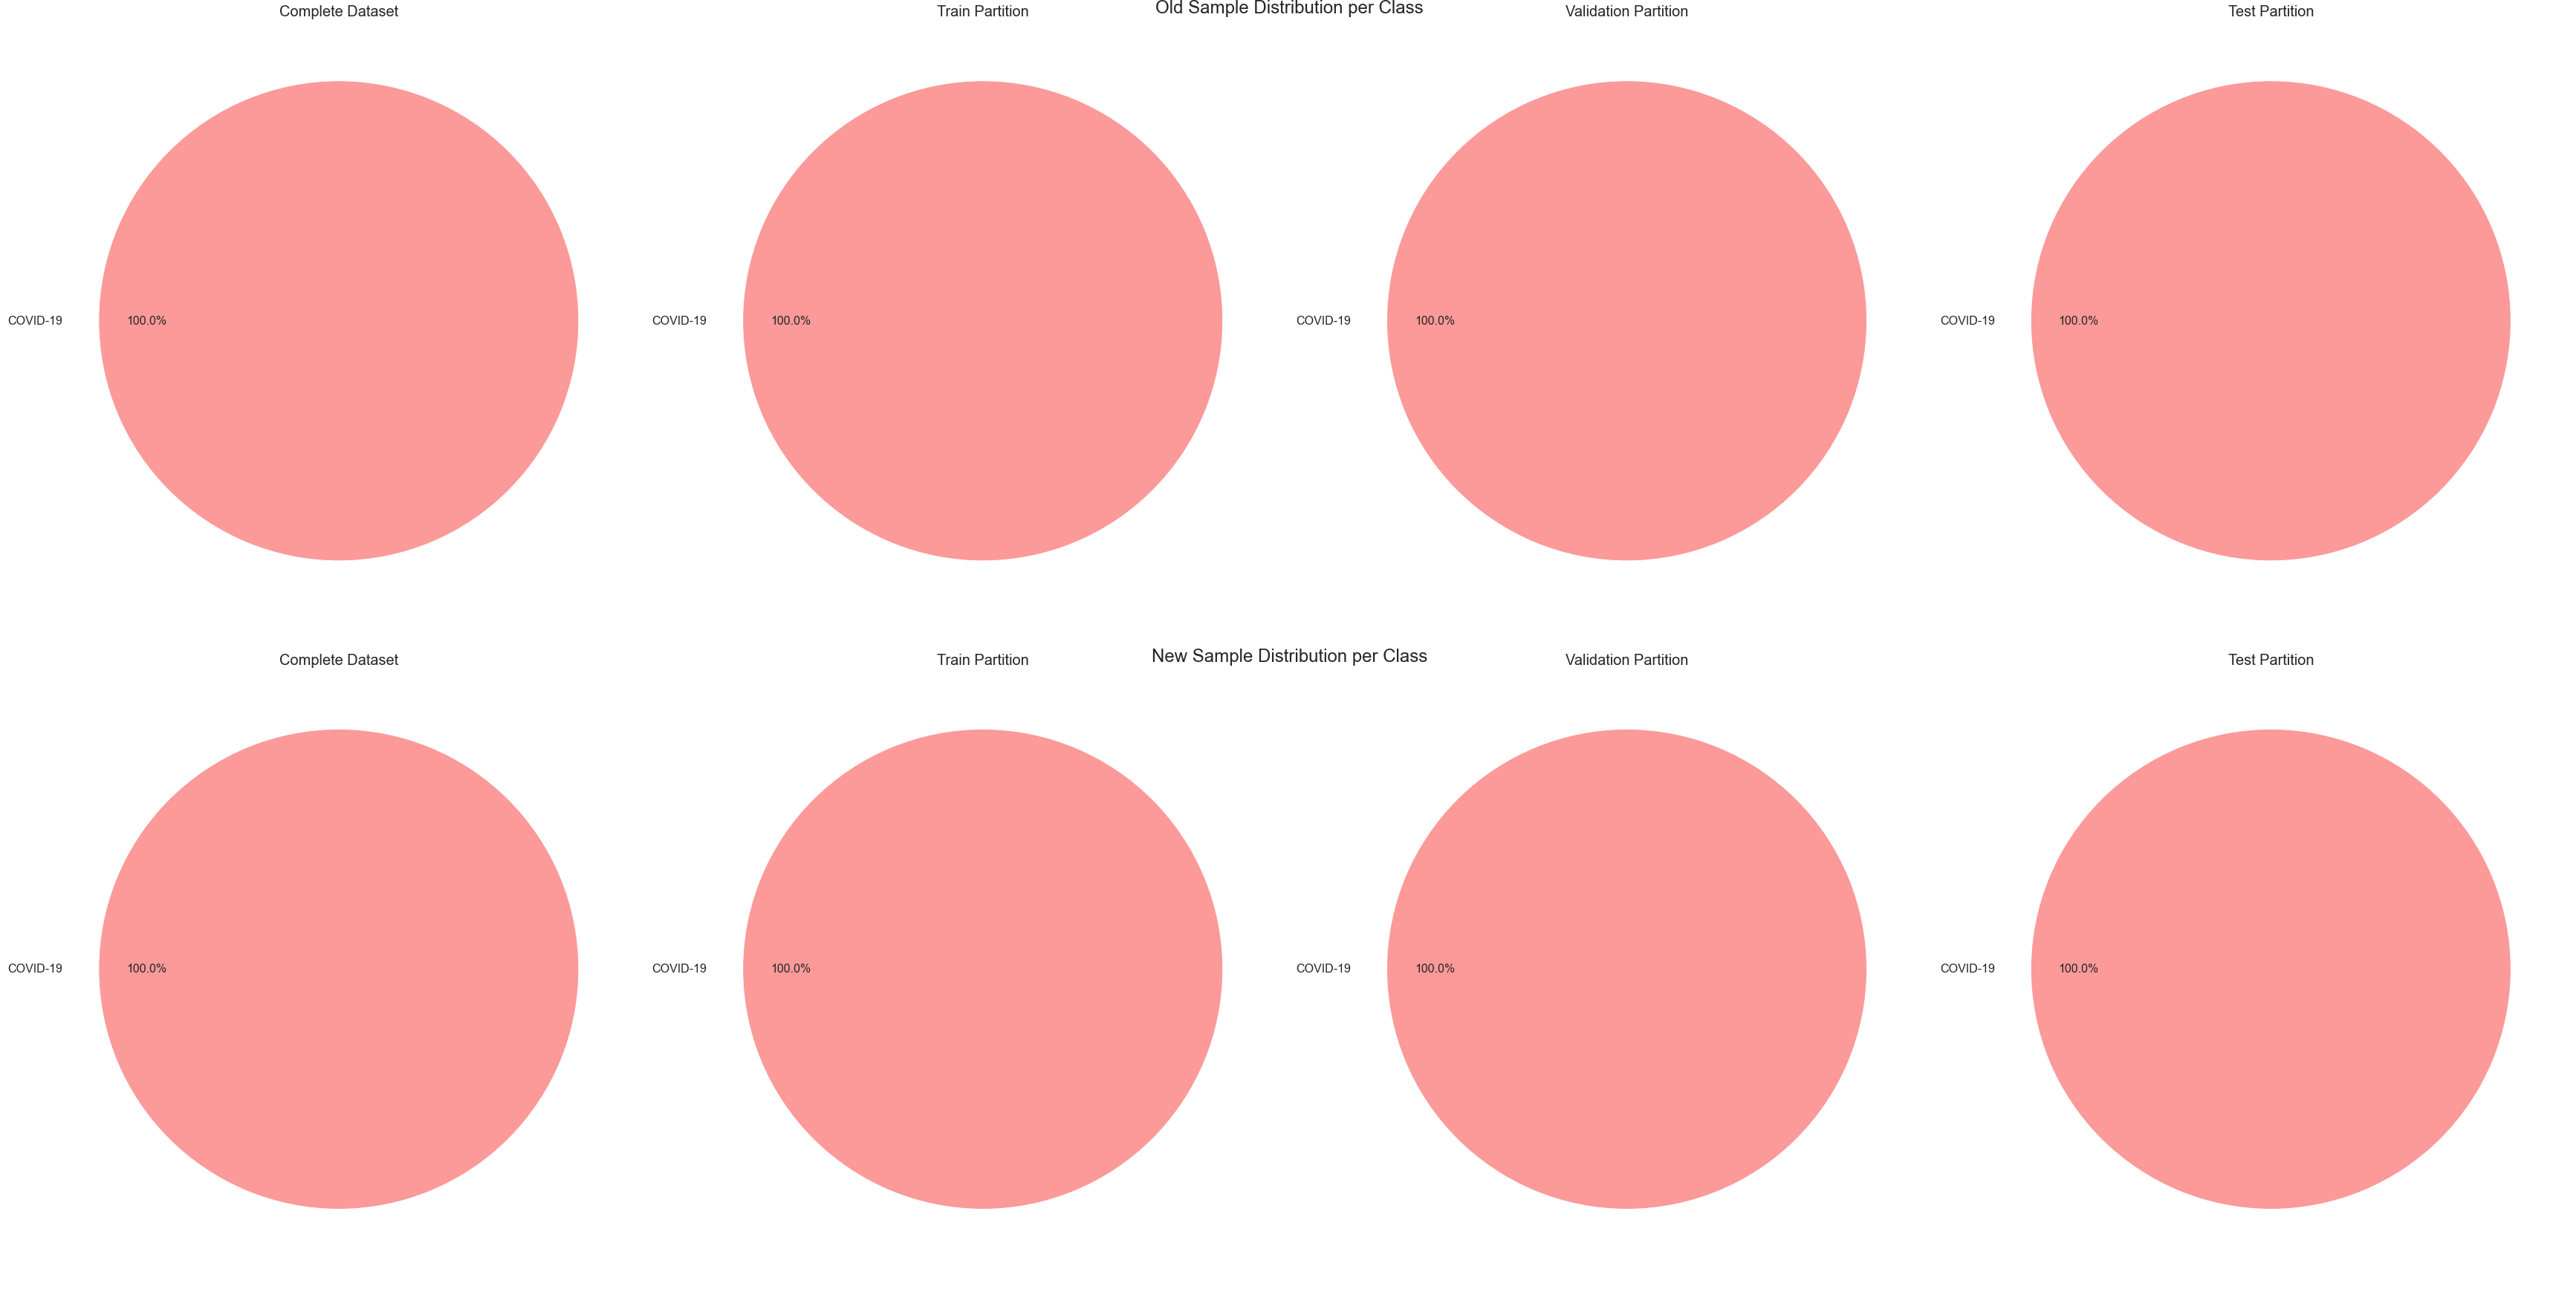

In [22]:
plot.column_as_pies( samples_df, new_samples_df, "class", dataset_name, figsize = (48, 24), resplit = True )

In [23]:
plot.column_as_table( samples_df, new_samples_df, "class", dataset_name, bin_flag = False, resplit = True )

,Dataset,Train,Val,Test
Values,,,,
COVID-19,11816,10044,885,887
Normal,0,0,0,0
Pneumonia,0,0,0,0
SUM,11816,10044,885,887
,Dataset,Train,Val,Test
Values,,,,
COVID-19,11816,7094,2361,2361
SUM,11816,7094,2361,2361


## Age

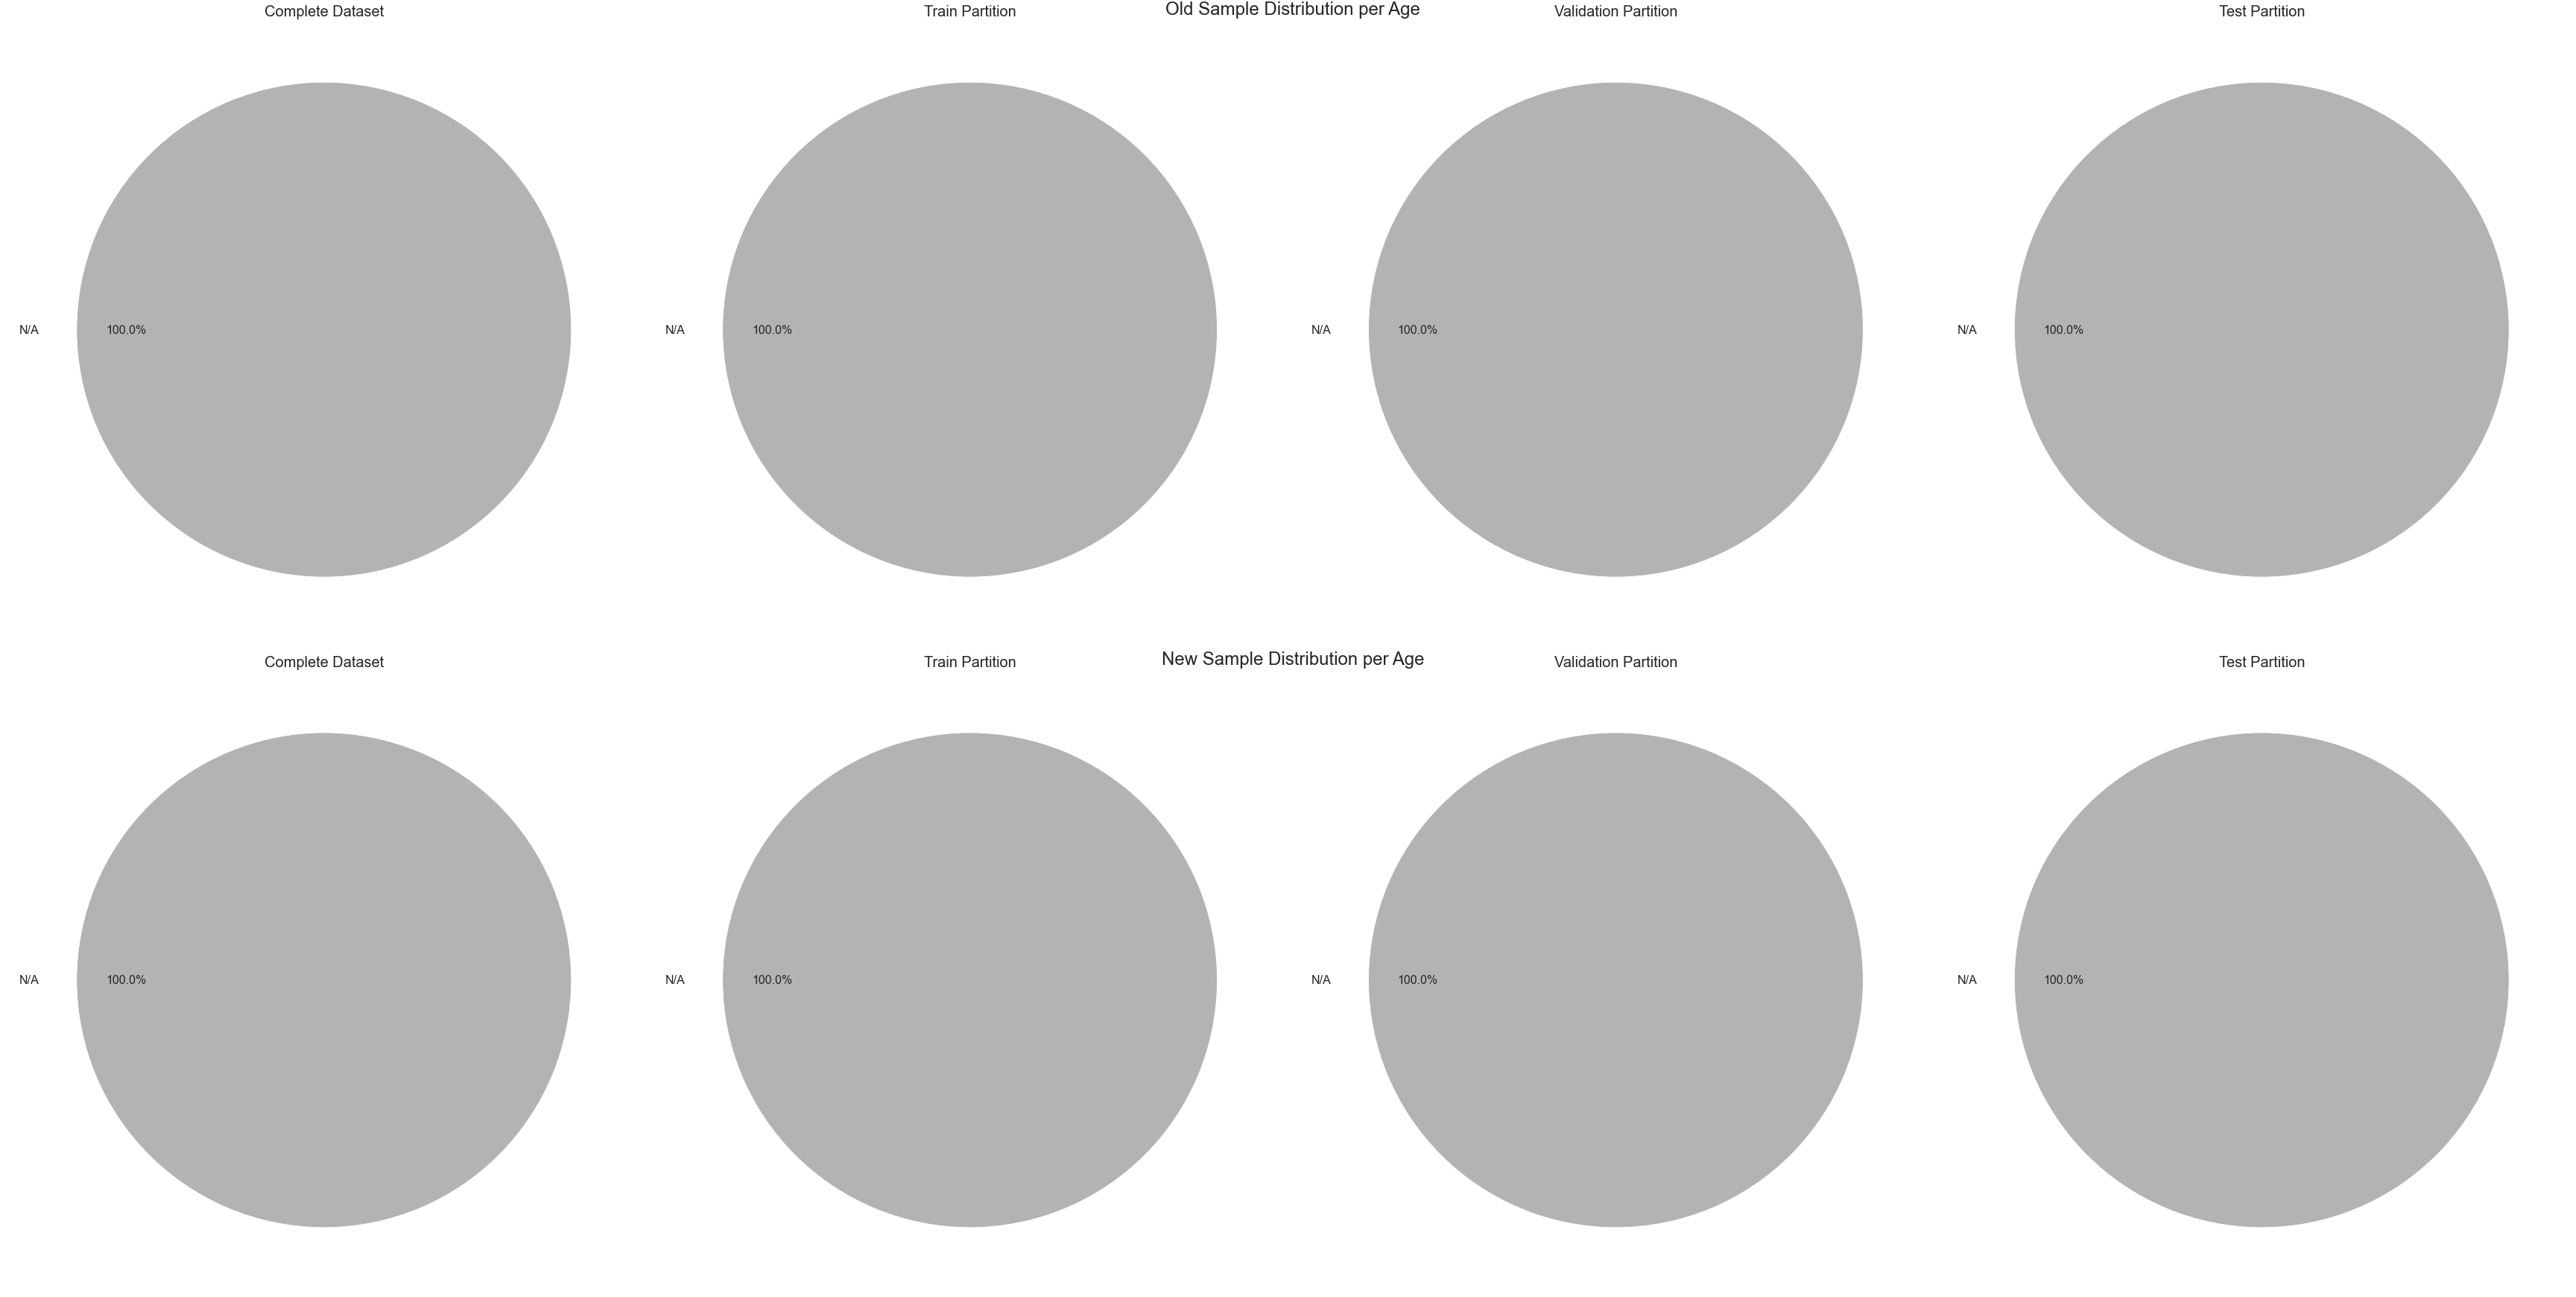

In [24]:
plot.column_as_pies( samples_df, new_samples_df, "age", dataset_name, figsize = (48, 24), resplit = True)

In [25]:
plot.column_as_table( samples_df, new_samples_df, "age", dataset_name, bin_flag = False, resplit = True )

,Dataset,Train,Val,Test
Values,,,,
N/A,11816,10044,885,887
Known Ages,0,0,0,0
SUM,11816,10044,885,887
,Dataset,Train,Val,Test
Values,,,,
N/A,11816,7094,2361,2361
SUM,11816,7094,2361,2361


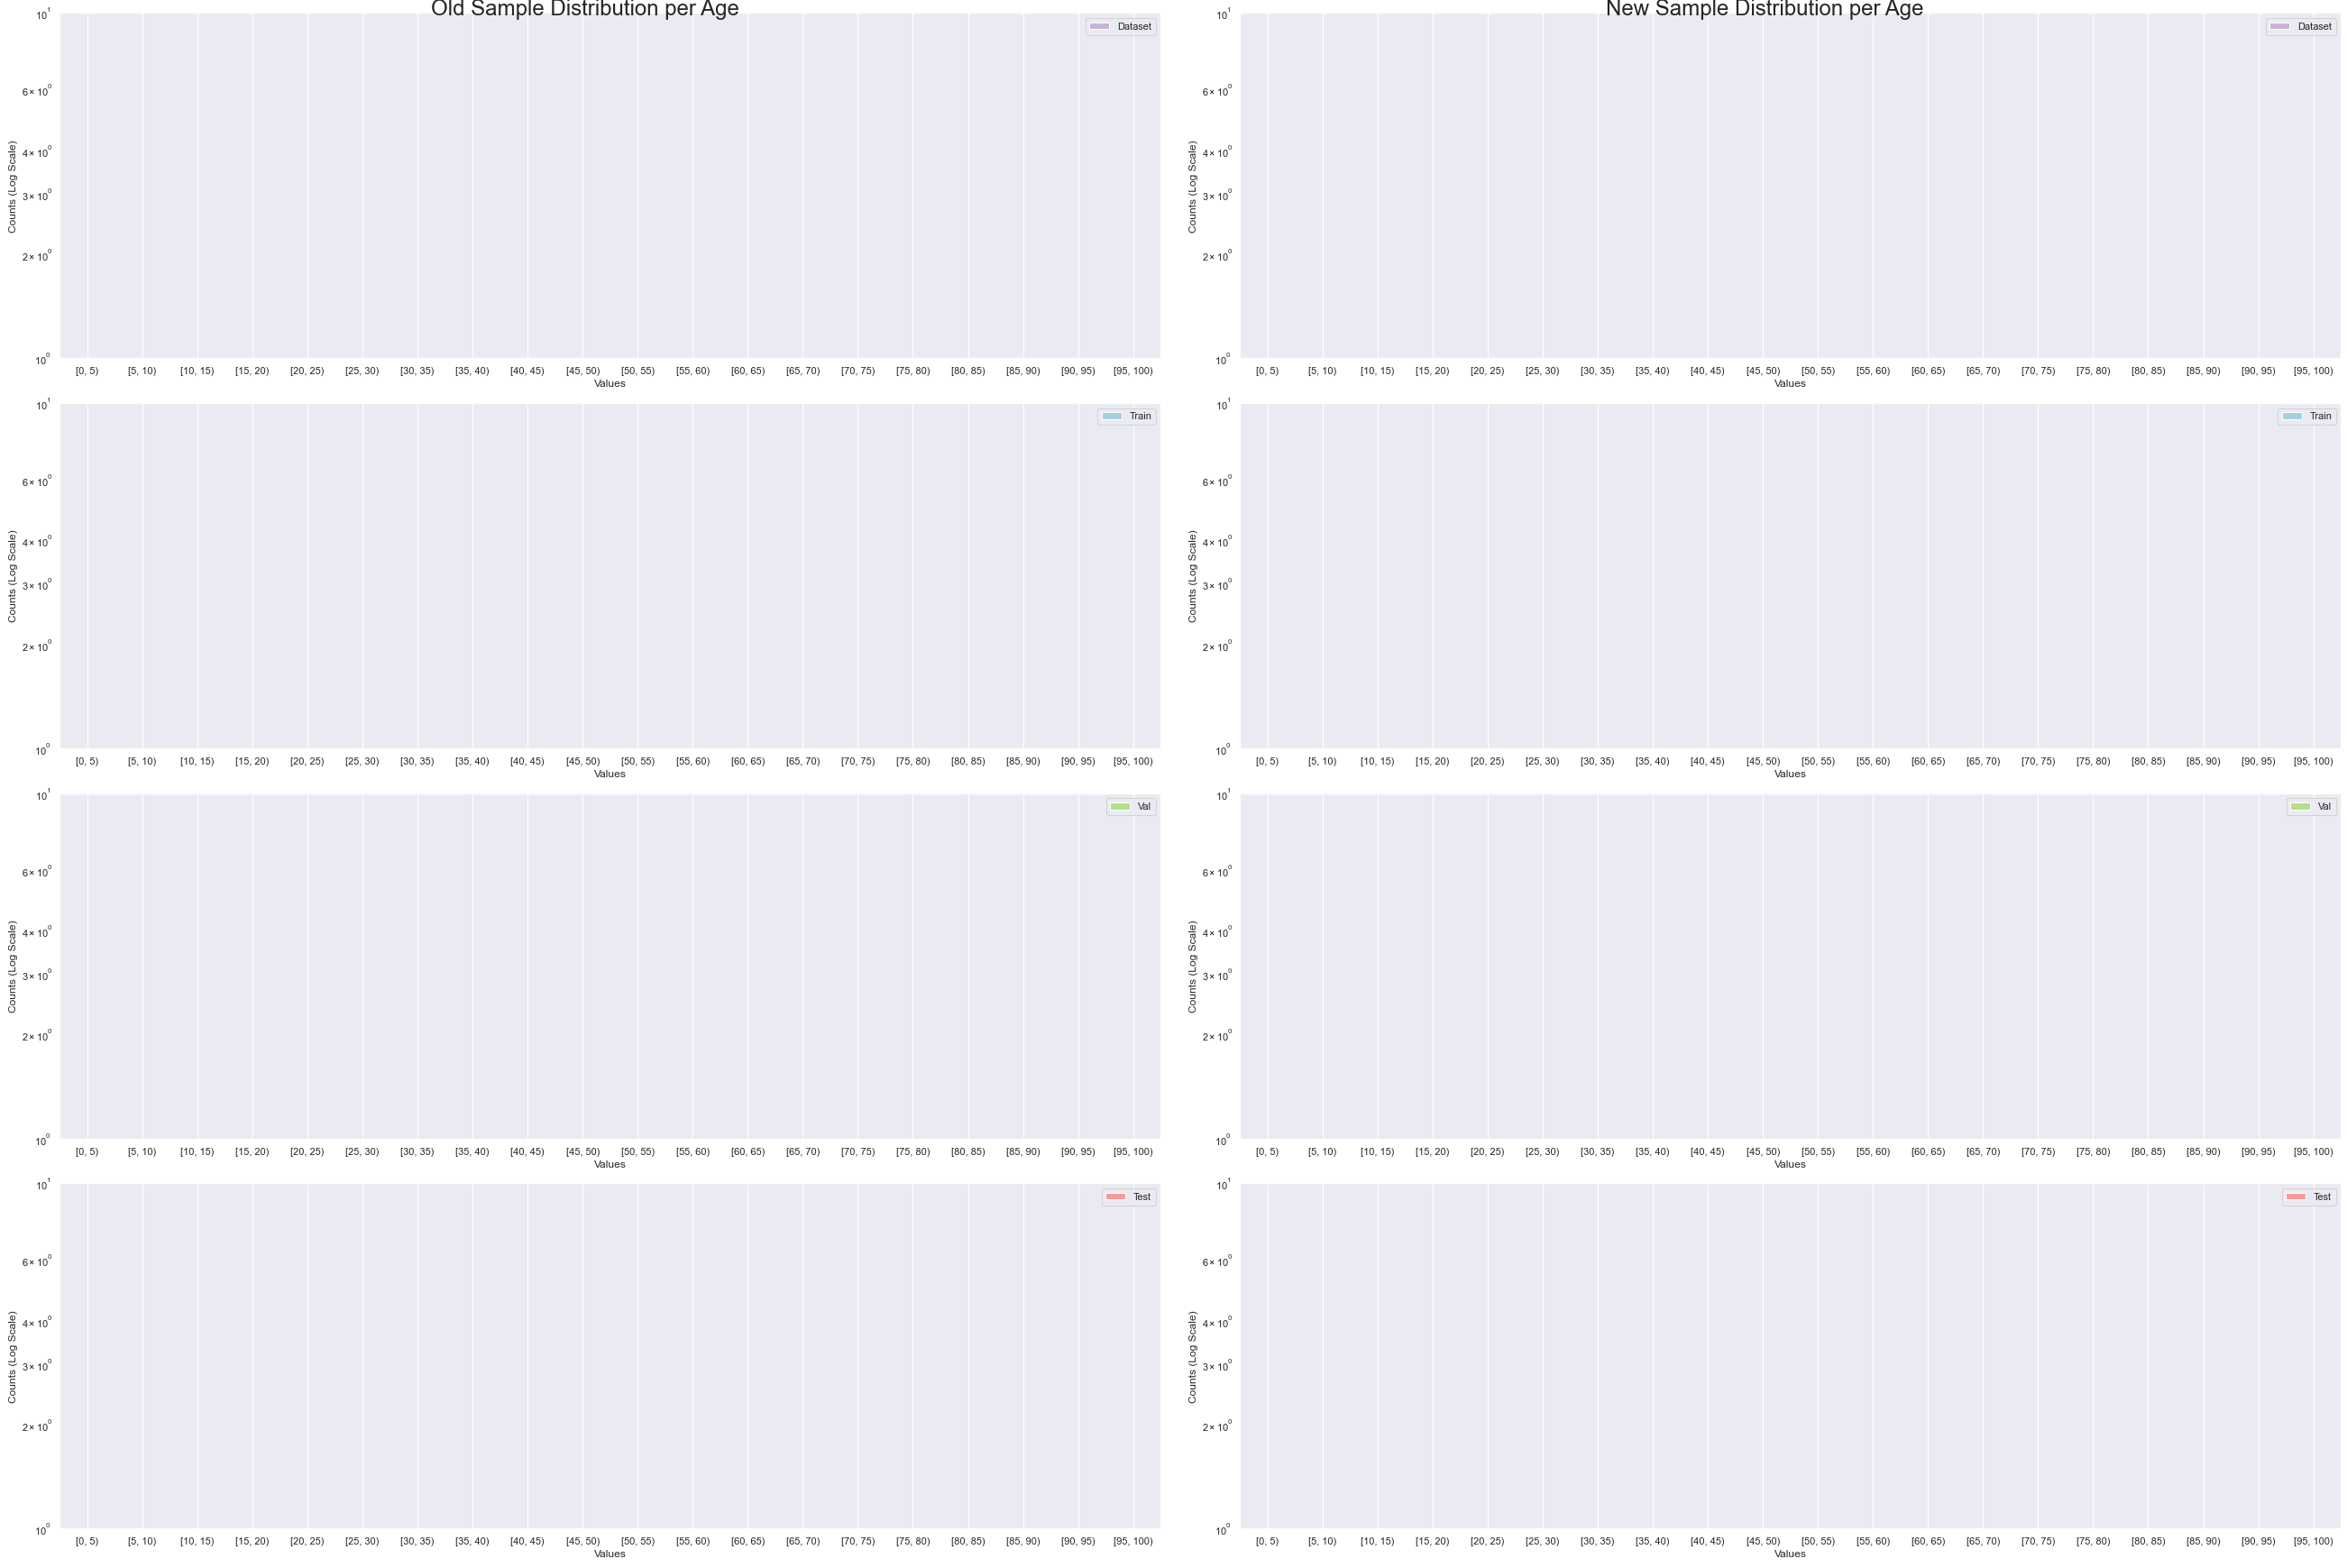

In [26]:
plot.column_as_histograms( samples_df, new_samples_df, "age", dataset_name, figsize = (36, 24), resplit = True)

In [27]:
plot.column_as_table( samples_df, new_samples_df, "age", dataset_name, bin_flag = True, resplit = True )

,Dataset,Train,Val,Test
Values,,,,
"[0, 5)",0,0,0,0
"[5, 10)",0,0,0,0
"[10, 15)",0,0,0,0
"[15, 20)",0,0,0,0
"[20, 25)",0,0,0,0
"[25, 30)",0,0,0,0
"[30, 35)",0,0,0,0
"[35, 40)",0,0,0,0
"[40, 45)",0,0,0,0


## Sex

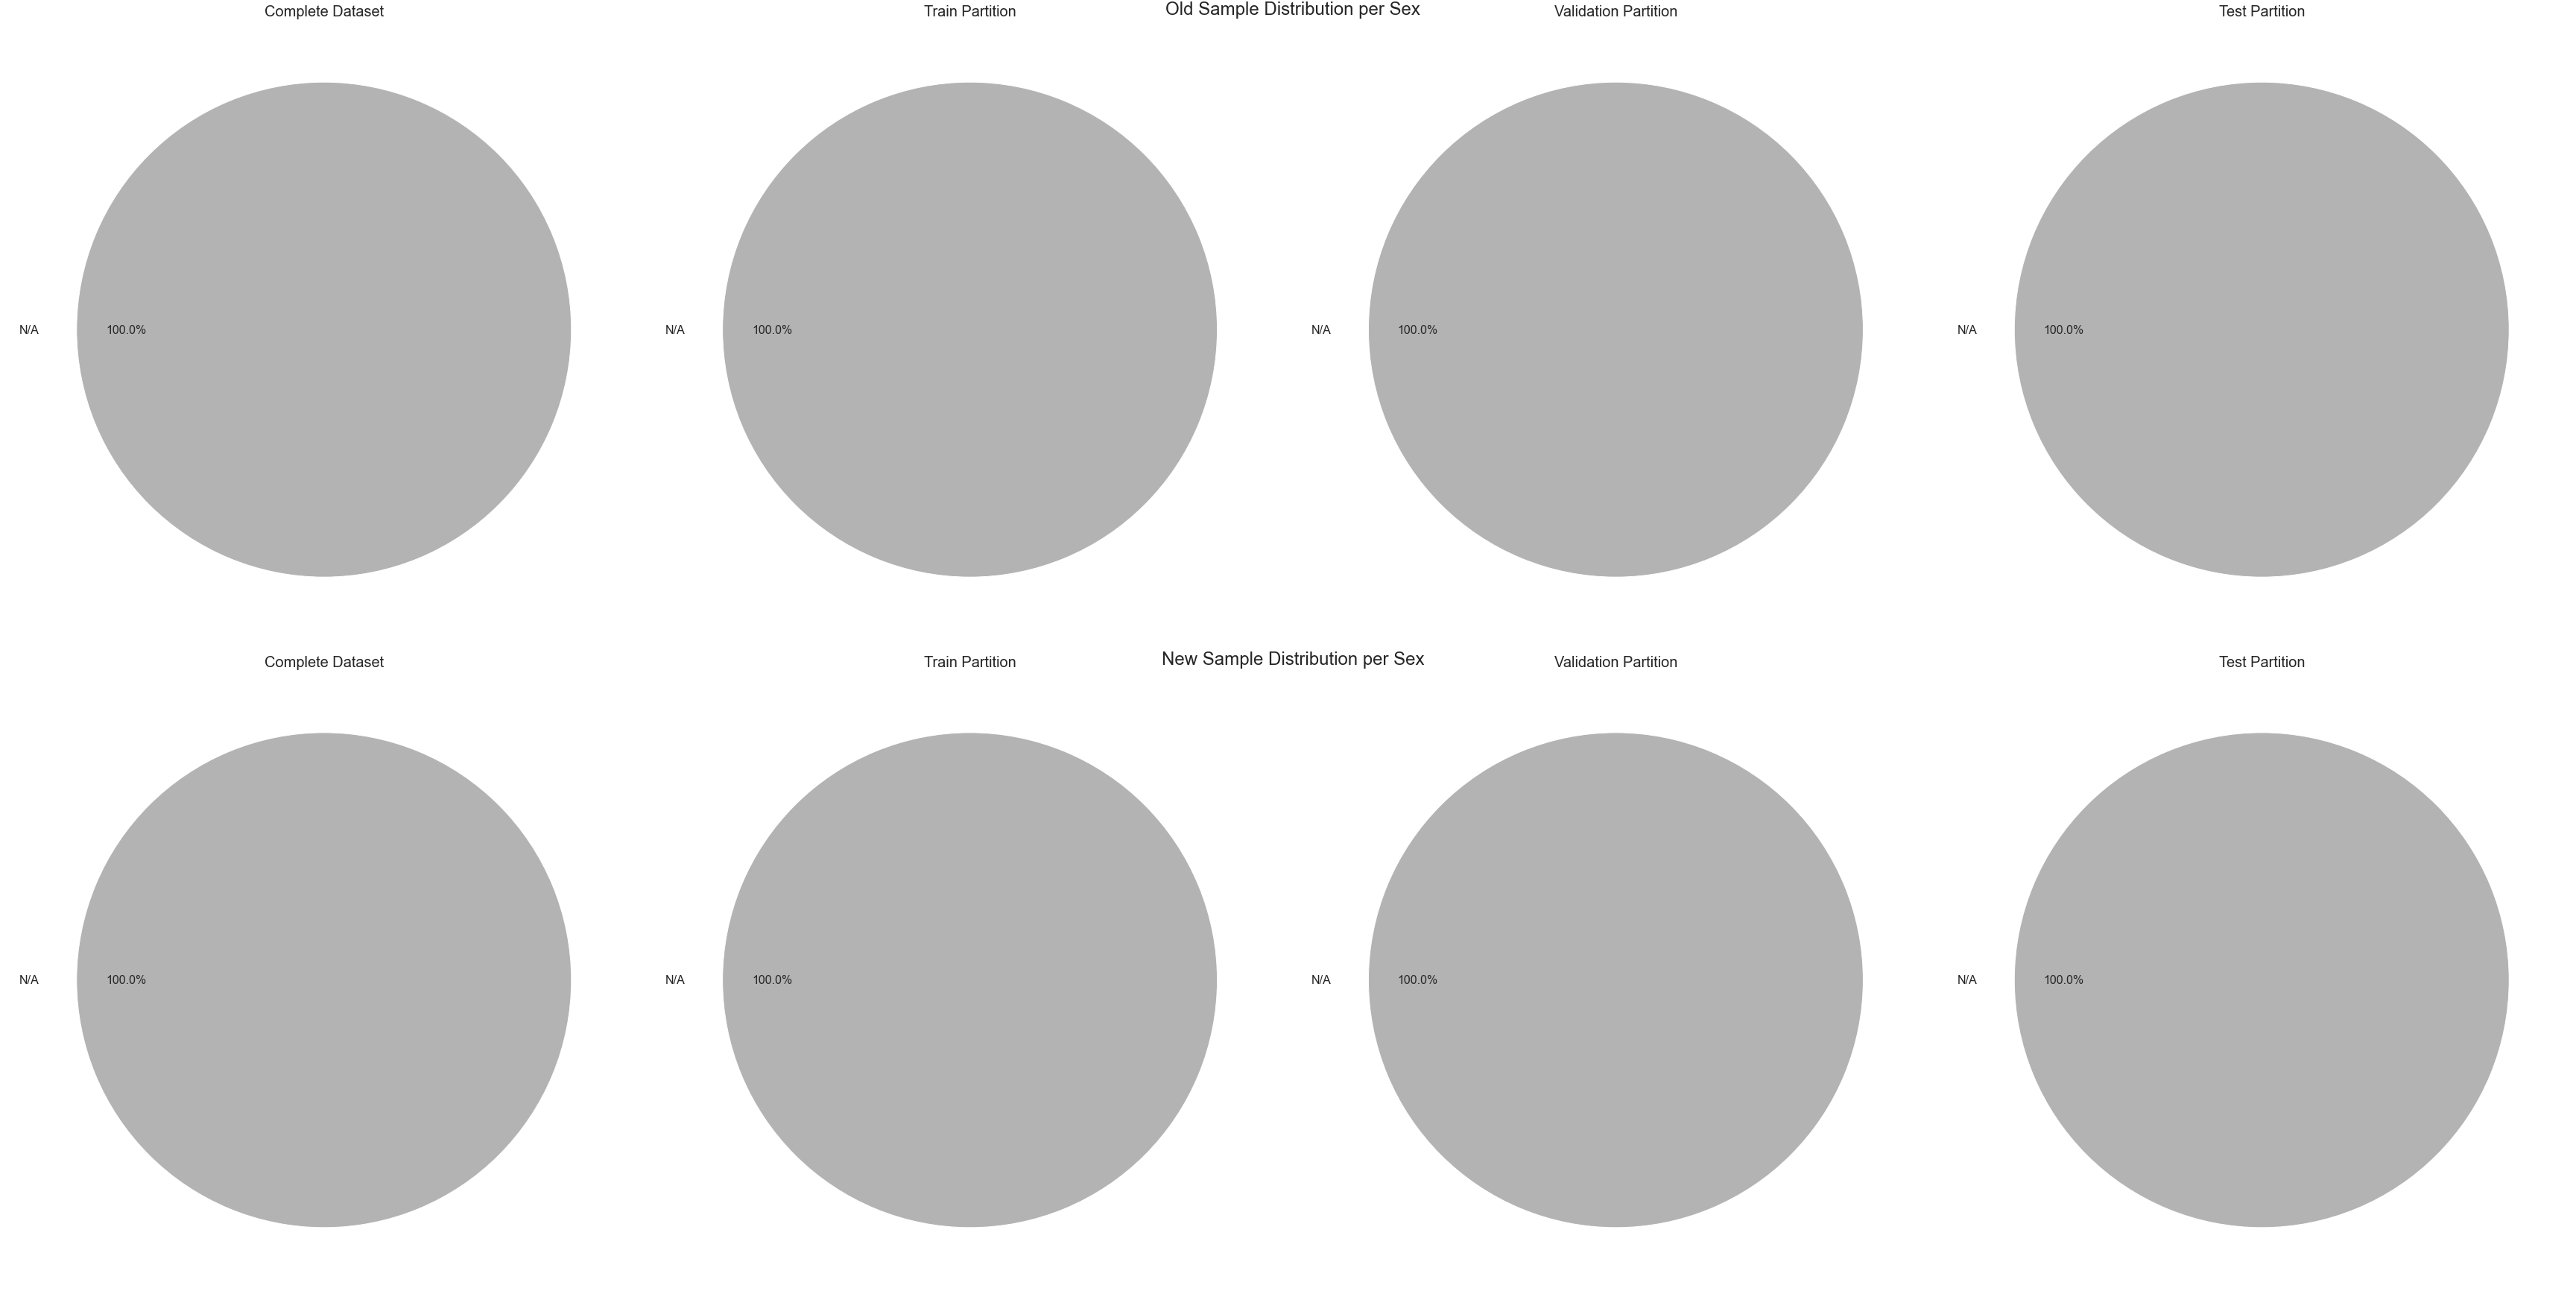

In [28]:
plot.column_as_pies( samples_df, new_samples_df, "sex", dataset_name, figsize = (48, 24), resplit = True )

In [29]:
plot.column_as_table( samples_df, new_samples_df, "sex", dataset_name, bin_flag = False, resplit = True )

,Dataset,Train,Val,Test
Values,,,,
M,0,0,0,0
N/A,11816,10044,885,887
F,0,0,0,0
SUM,11816,10044,885,887
,Dataset,Train,Val,Test
Values,,,,
N/A,11816,7094,2361,2361
SUM,11816,7094,2361,2361


## Country

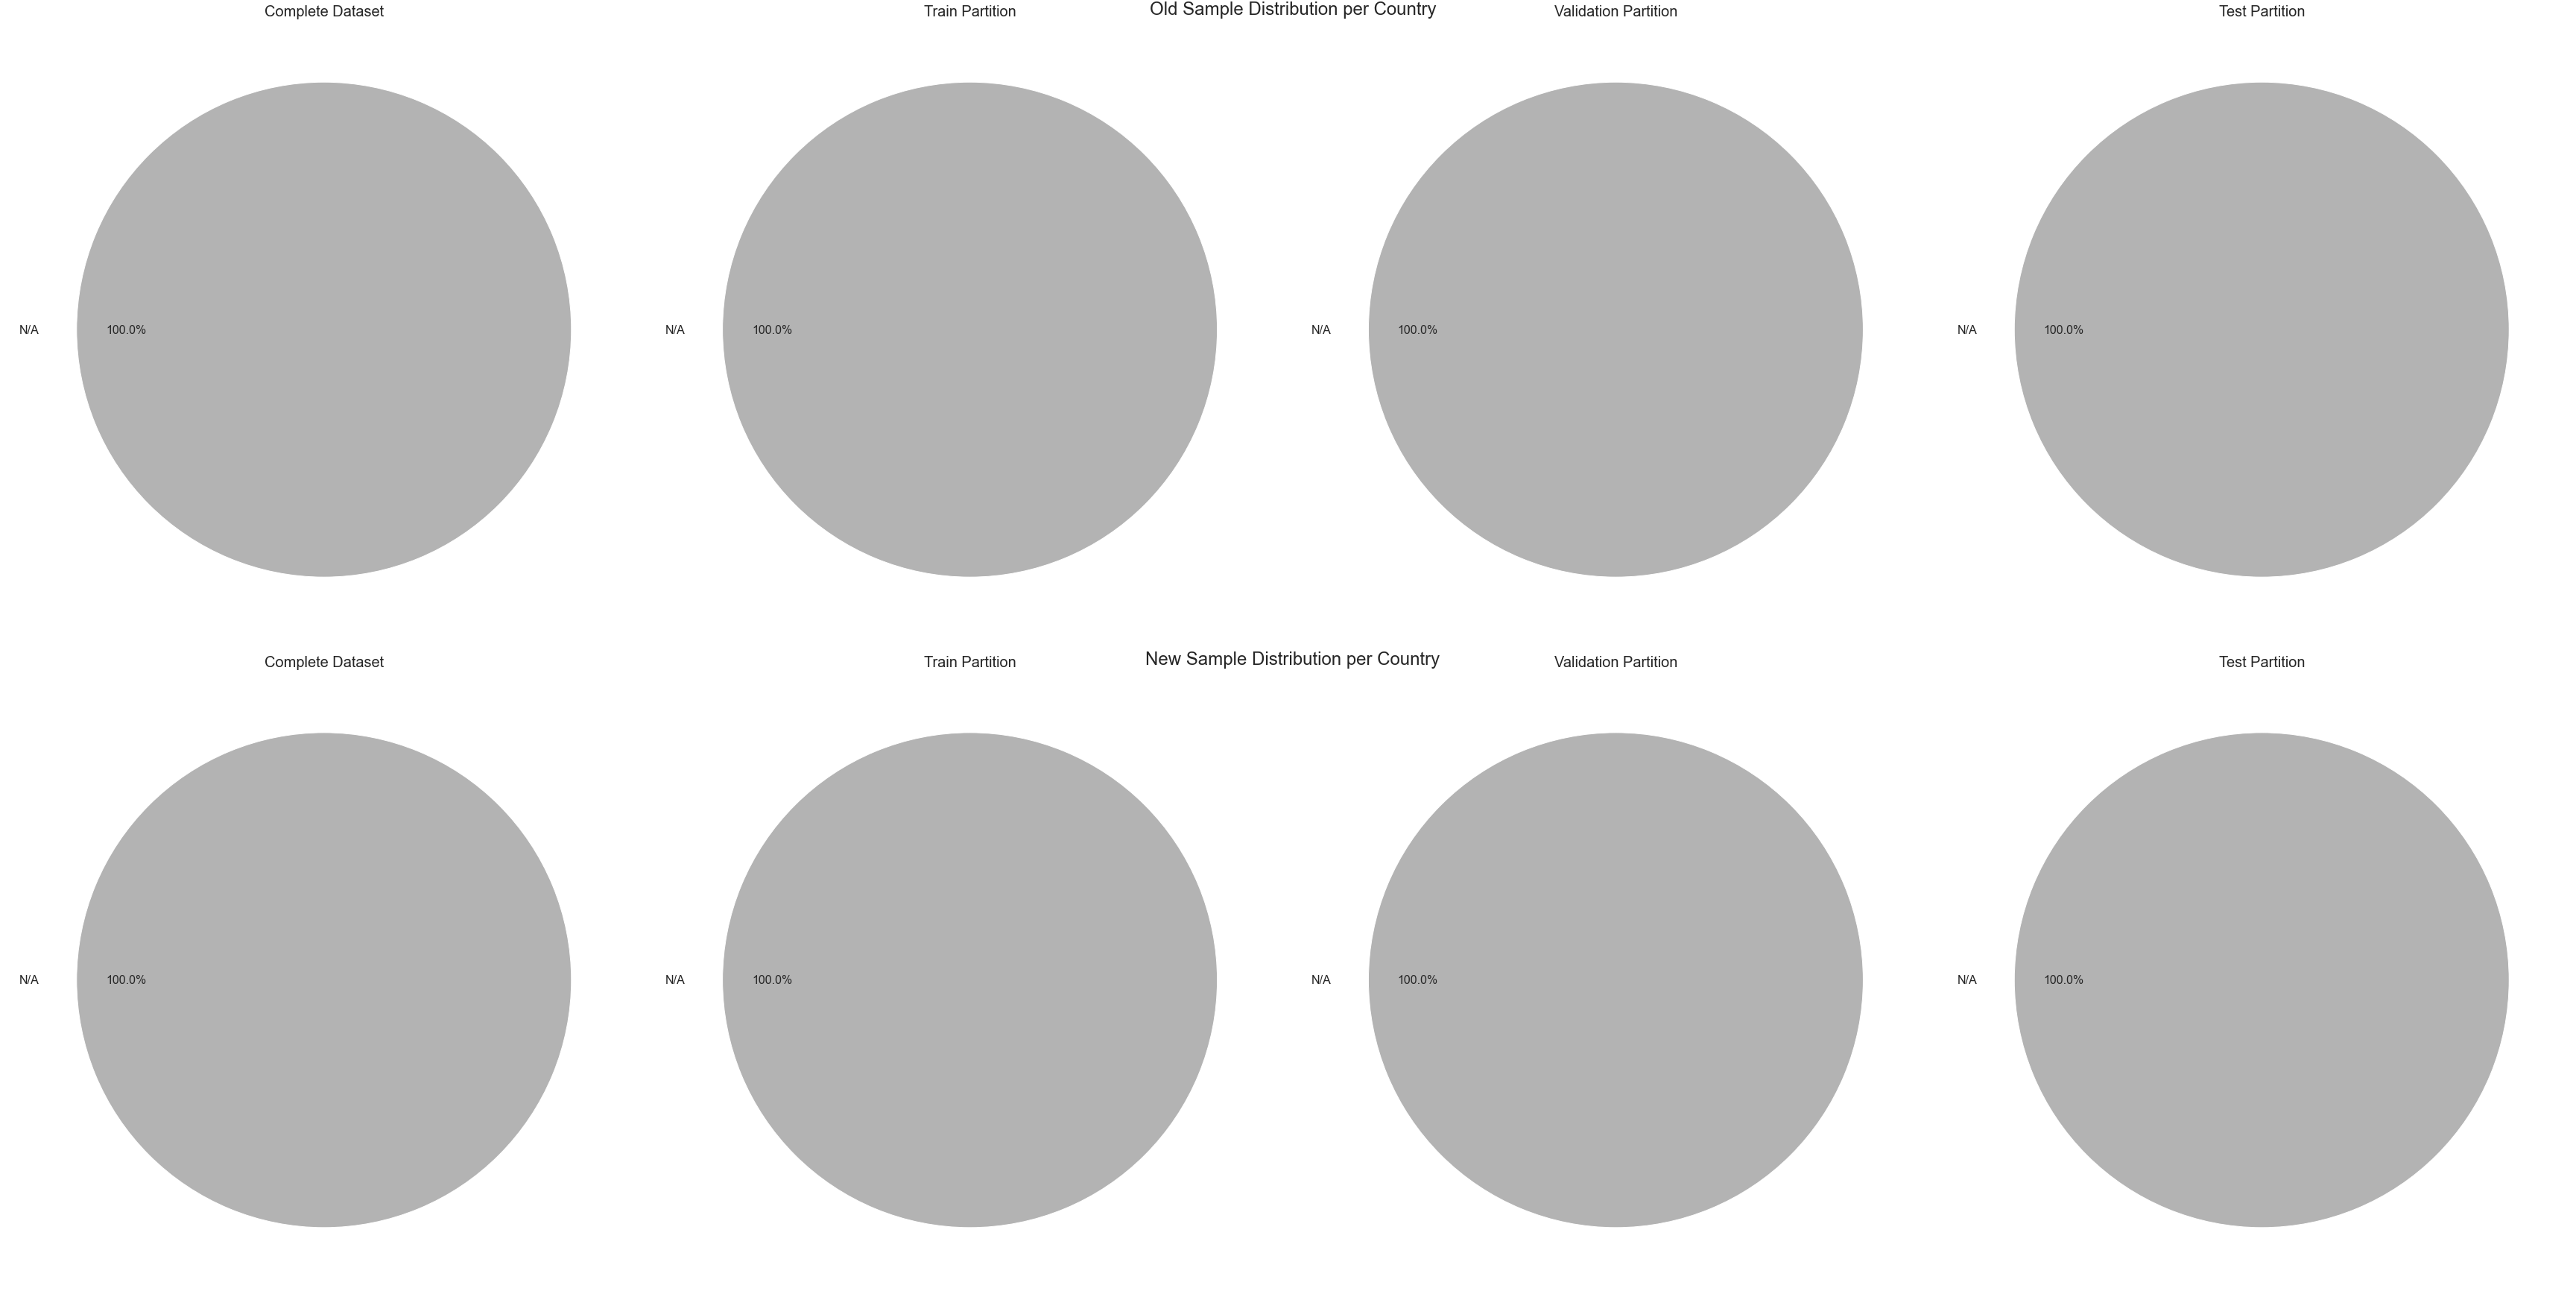

In [30]:
plot.column_as_pies( samples_df, new_samples_df, "country", dataset_name, figsize = (48, 24), resplit = True )

In [31]:
plot.column_as_table( samples_df, new_samples_df, "country", dataset_name, bin_flag = False, resplit = True )

,Dataset,Train,Val,Test
Values,,,,
France,0,0,0,0
China,0,0,0,0
Iran,0,0,0,0
USA,0,0,0,0
N/A,11816,10044,885,887
Australia,0,0,0,0
Italy,0,0,0,0
Algeria,0,0,0,0
Belgium,0,0,0,0


## Partition

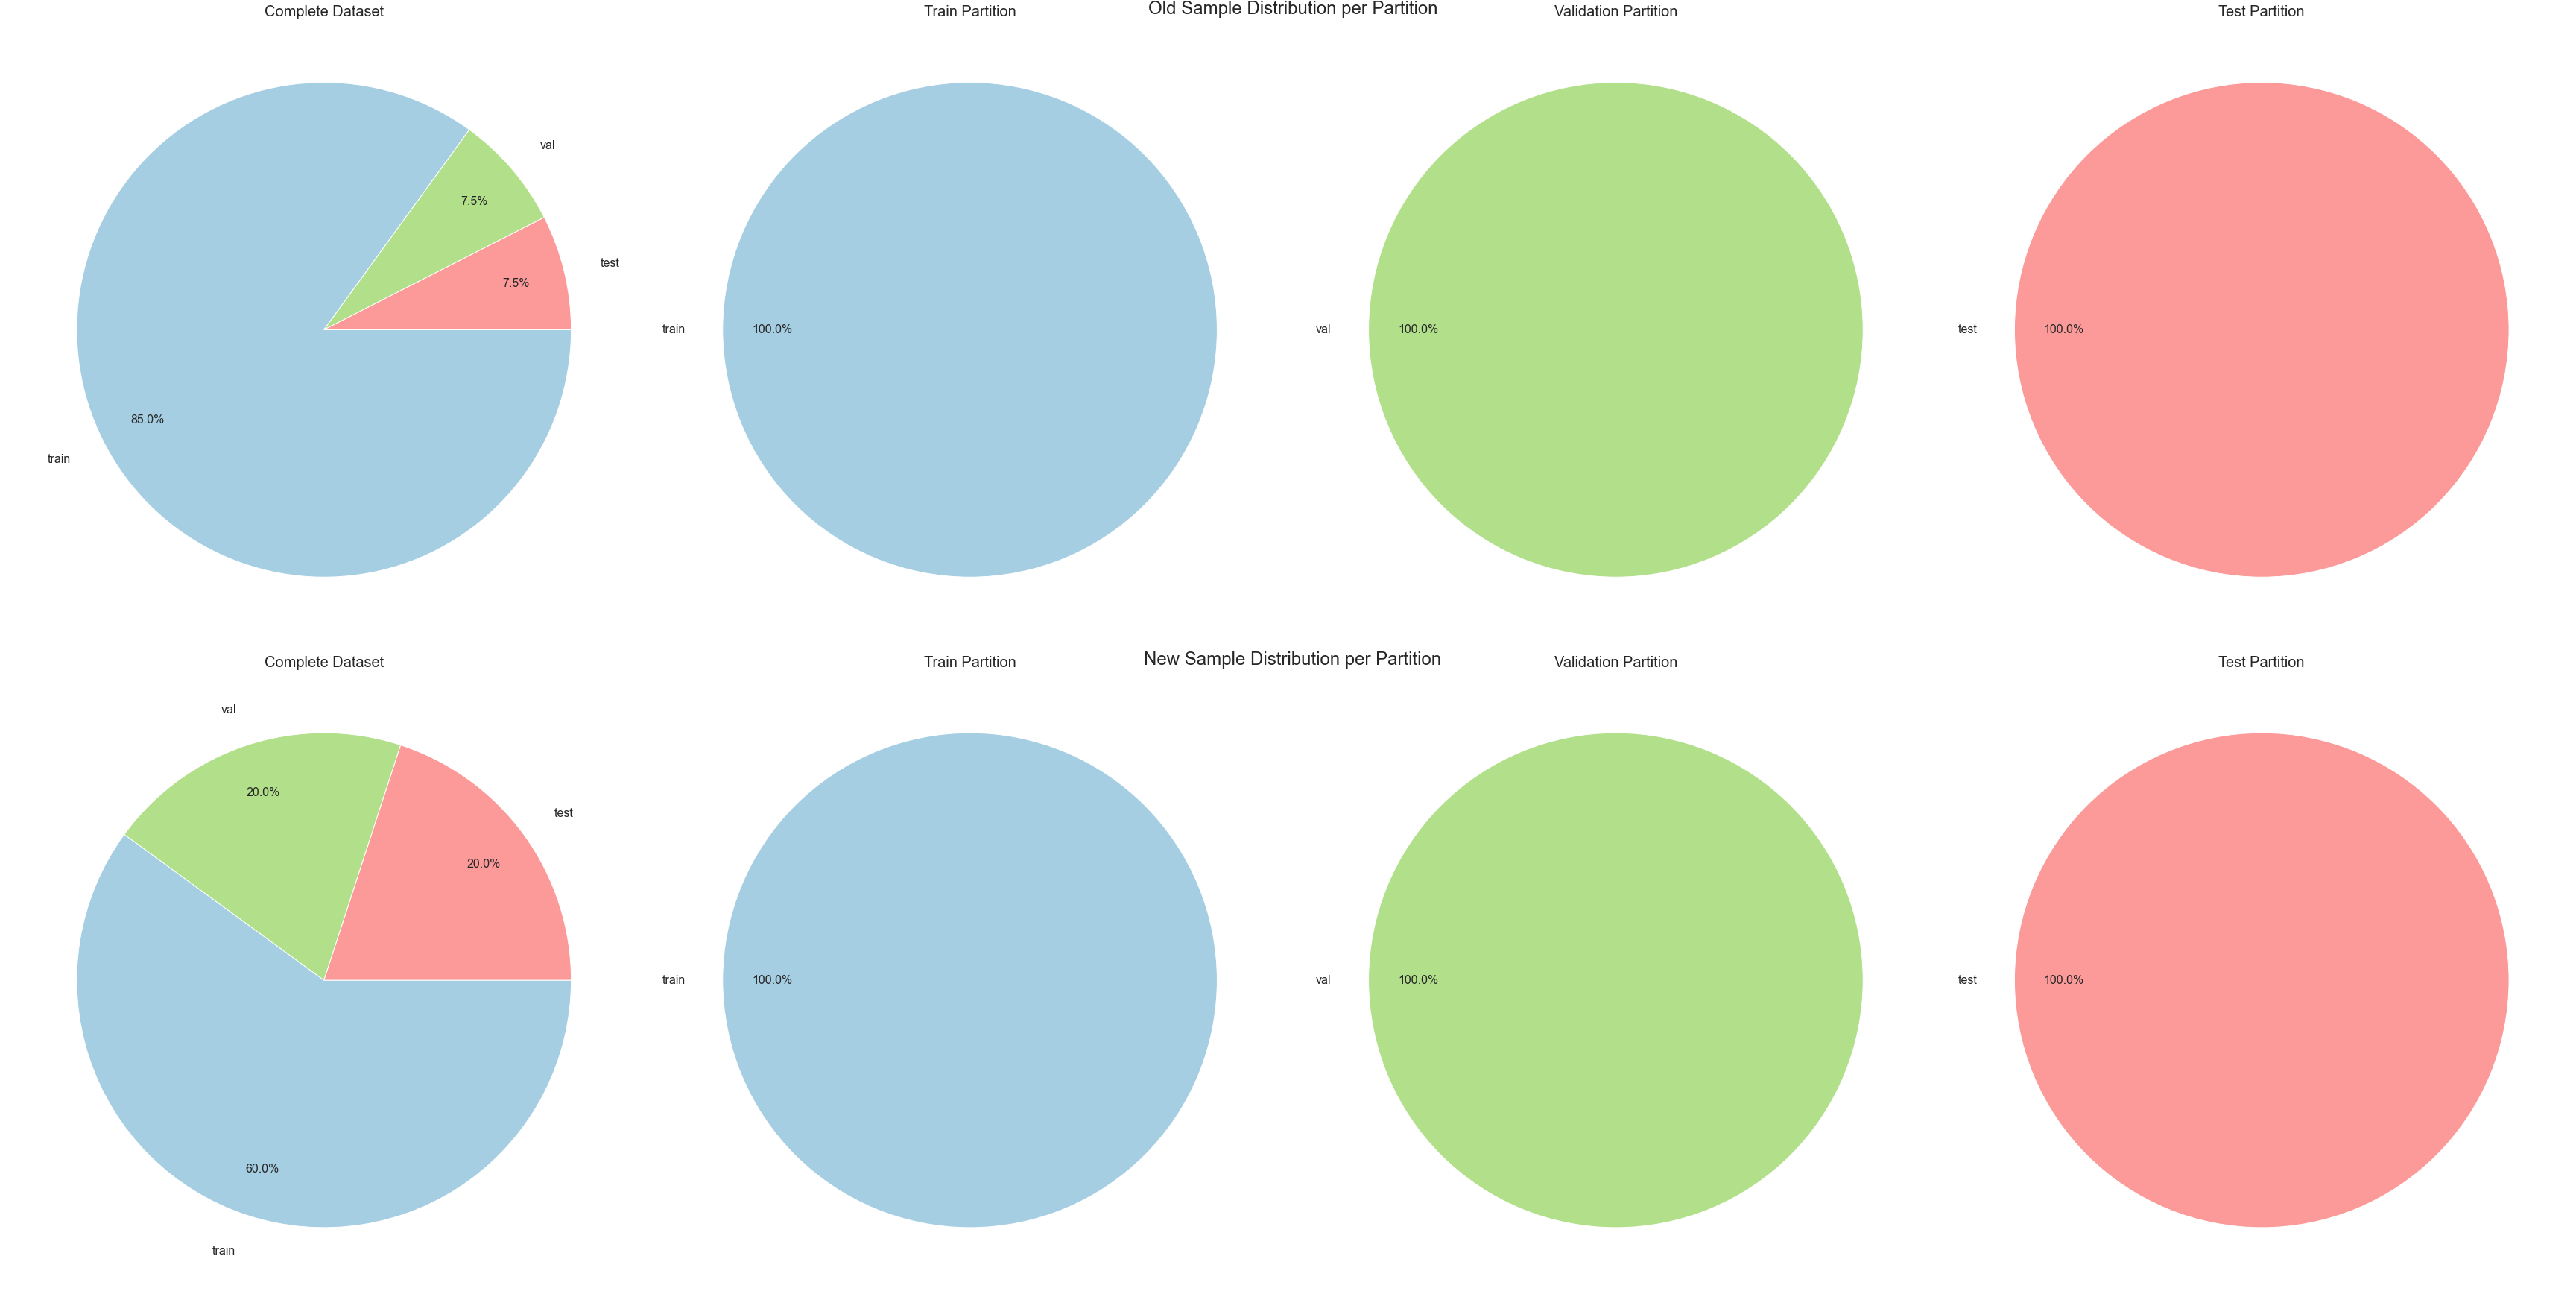

In [32]:
plot.column_as_pies( samples_df, new_samples_df, "partition", dataset_name, figsize = (48, 24), resplit = True )

In [33]:
plot.column_as_table( samples_df, new_samples_df, "partition", dataset_name, bin_flag = False, resplit = True )

,Dataset,Train,Val,Test
Values,,,,
train,10044,10044,0,0
test,887,0,0,887
val,885,0,885,0
SUM,11816,10044,885,887
,Dataset,Train,Val,Test
Values,,,,
train,7094,7094,0,0
test,2361,0,0,2361
val,2361,0,2361,0


## Slice Selection

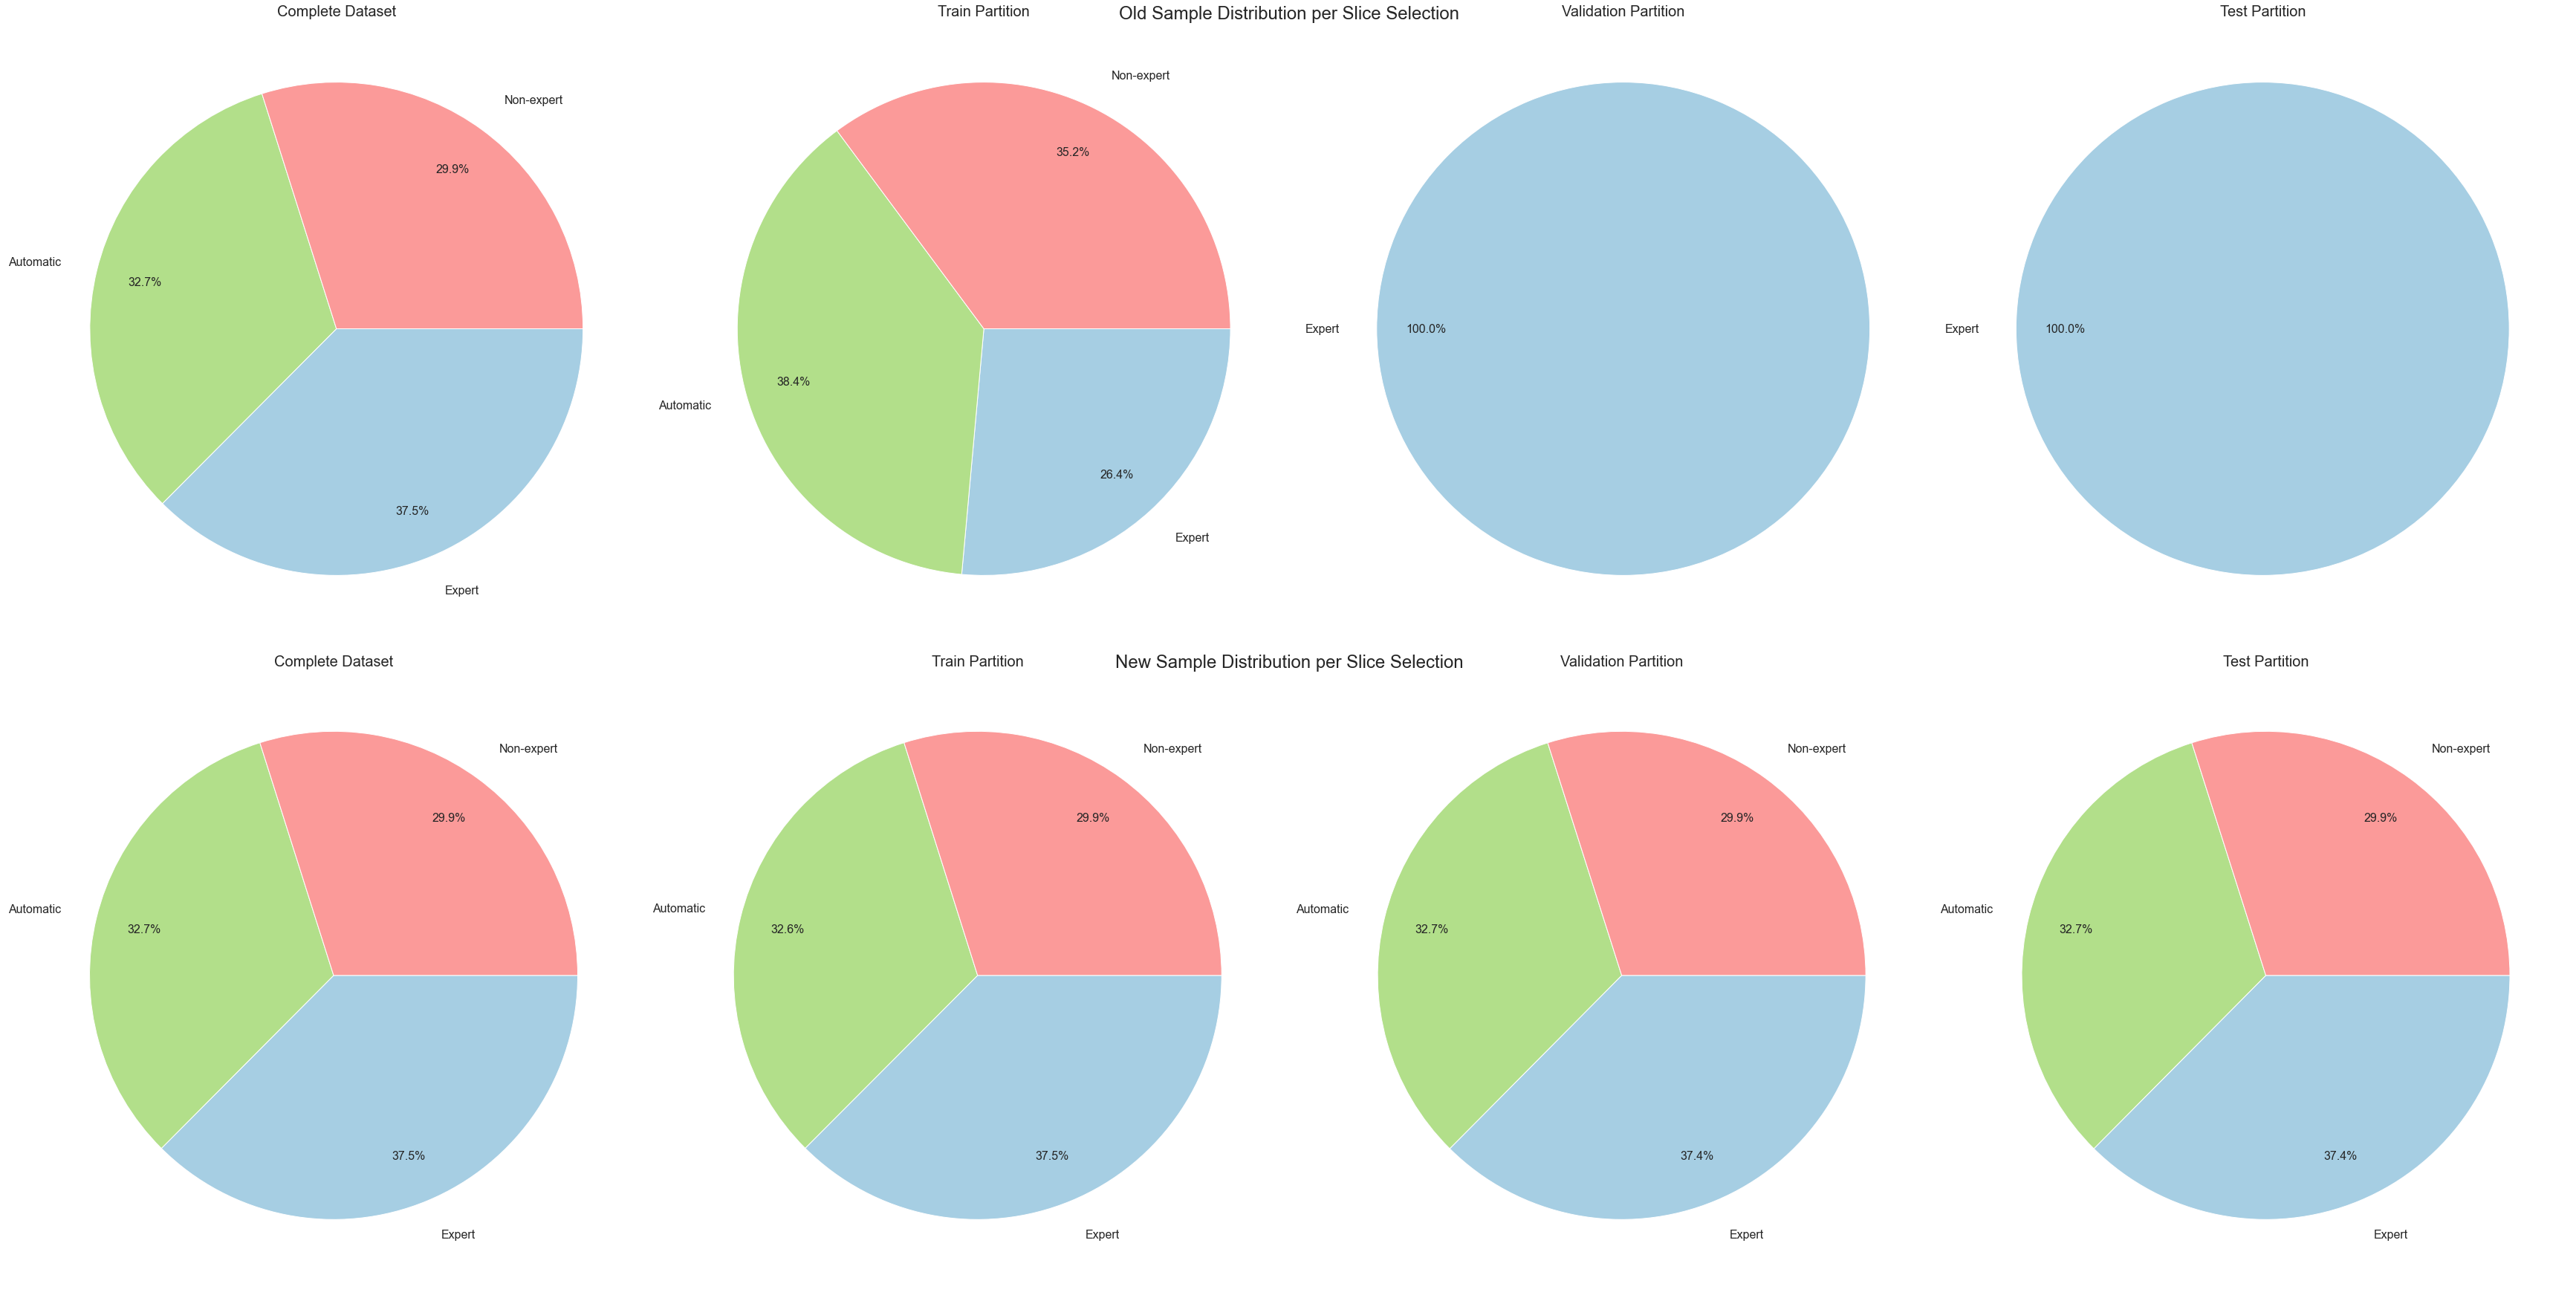

In [34]:
plot.column_as_pies( samples_df, new_samples_df, "slice_selection", dataset_name, figsize = (48, 24), resplit = True )

In [35]:
plot.column_as_table( samples_df, new_samples_df, "slice_selection", dataset_name, bin_flag = False, resplit = True )

,Dataset,Train,Val,Test
Values,,,,
Automatic,3858,3858,0,0
Expert,4427,2655,885,887
N/A,0,0,0,0
Non-expert,3531,3531,0,0
SUM,11816,10044,885,887
,Dataset,Train,Val,Test
Values,,,,
Expert,4427,2659,884,884
Automatic,3858,2316,771,771


# Registering Changes

In [36]:
# Path to save new metadata csv
csv_export_path = os.path.join( data_dir, "new_split_metadata.csv" )

updated_df = split.update_metadata_csv( csv_export_path, new_samples_df, dataset_name, save_bool = True )
print( len(updated_df), len(new_samples_df) )
updated_df.head()

189197 11816


,filename,patient_id,source,class,country,sex,age,partition,slice_selection,x_min,y_min,x_max,y_max,verified_finding,view,modality
0,NCP_96_1328_0032.png,NCP_96,CNCB,COVID-19,China,M,74.0,train,Expert,9,94,512,405,Yes,Axial,CT
1,NCP_96_1328_0035.png,NCP_96,CNCB,COVID-19,China,M,74.0,train,Expert,10,106,512,405,Yes,Axial,CT
2,NCP_96_1328_0036.png,NCP_96,CNCB,COVID-19,China,M,74.0,train,Expert,10,105,512,406,Yes,Axial,CT
3,NCP_96_1328_0037.png,NCP_96,CNCB,COVID-19,China,M,74.0,train,Expert,11,104,512,406,Yes,Axial,CT
4,NCP_96_1328_0038.png,NCP_96,CNCB,COVID-19,China,M,74.0,train,Expert,11,103,512,406,Yes,Axial,CT
